### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- write currently uses a complex prompt with all the stories instead
  - filter to eg top 50 by rating
  - ignoring stories with already assigned bucket, use a model_medium prompt to put each story in an existing topic bucket, or other
  - write a section independently for each non-empty topic bucket using model_high
  - assemble all the sections and rewrite using a critic-refine flow
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts
- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
# before_date = '2025-05-14 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name']]


In [ ]:
aidf.columns


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-20 08:09:35,117 - AInewsbot - INFO - Initializing with before_date=2025-05-19 20:00, do_download=False, thread_id=d17ecfc78cc8499e88575c22b1a502fe


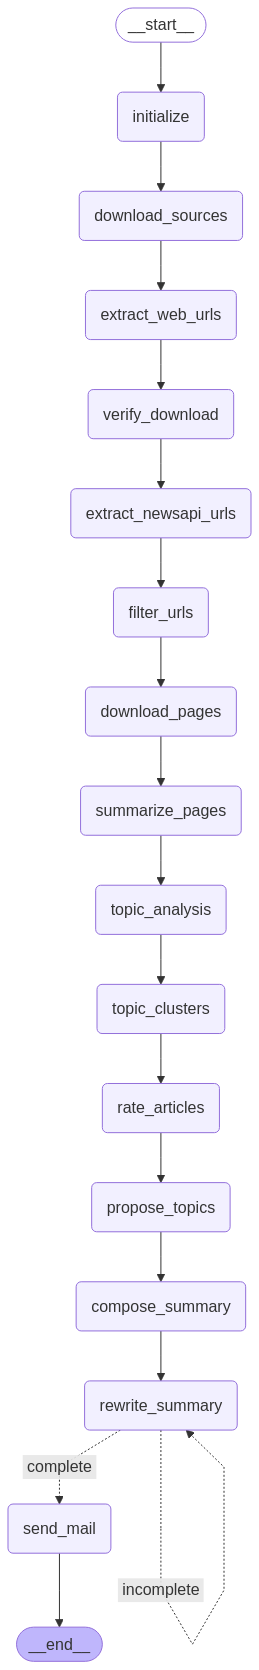

In [12]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-19 20:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [13]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-20 08:09:35,758 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-20 08:09:35,759 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-20 08:09:35,759 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-20 08:09:35,759 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-20 08:09:35,760 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-20 08:09:35,760 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-20 08:09:35,760 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [14]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-20 08:09:36,701 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-20 08:09:36,703 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-20 08:09:36,704 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-20 08:09:36,704 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-20 08:09:36,705 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-20 08:09:36,705 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-20 08:09:36,706 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-20 08:09:36,706 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-20 08:09:36,707 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-20 08:09:36,707 - AInewsbot - INFO - htmldata/FT.html
2025-05-20 08:09:36,707 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-20 08:09:36,707 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-20 08:09:36,708 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-20 08:09:36,708 - AInewsbot - INFO -

In [15]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-20 08:09:37,093 - AInewsbot - INFO - Parsing html files
2025-05-20 08:09:37,095 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-20 08:09:37,138 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-20 08:09:37,140 - AInewsbot - INFO - parse_file - found 31 filtered links
2025-05-20 08:09:37,141 - AInewsbot - INFO - 31 links found
2025-05-20 08:09:37,141 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-20 08:09:37,165 - AInewsbot - INFO - parse_file - found 255 raw links
2025-05-20 08:09:37,168 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-20 08:09:37,169 - AInewsbot - INFO - 37 links found
2025-05-20 08:09:37,169 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-20 08:09:37,187 - AInewsbot - INFO - parse_file - found 217 raw links
2025-05-20 08:09:37,190 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-20 08:09:37,190 - AInewsbot - INFO - 21 links found
2025-05-20

In [16]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,31
Bloomberg,30
Business Insider,21
FT,63
Feedly AI,123
Hacker News 1,20
Hacker News 2,21
HackerNoon,20
New York Times,19


number of missing sources 0


set()

In [17]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-20 08:09:37,982 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [18]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-20 08:09:39,635 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-19T08:09:39 from NewsAPI


In [19]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-20 08:09:40,892 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-19 20:00'
2025-05-20 08:09:41,582 - AInewsbot - INFO - URLs in orig_df: 947
2025-05-20 08:09:41,585 - AInewsbot - INFO - Existing URLs in DB: 261082
2025-05-20 08:09:41,644 - AInewsbot - INFO - New URLs in df filtered by URL: 439
2025-05-20 08:09:41,771 - AInewsbot - INFO - Existing src+title: 37
2025-05-20 08:09:41,771 - AInewsbot - INFO - New URLs in df filtered by src+title: 402
2025-05-20 08:09:41,785 - AInewsbot - INFO - Found 402 unique new headlines
2025-05-20 08:09:41,787 - AInewsbot - INFO - Found 395 unique cleaned new headlines
2025-05-20 08:09:47,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:09:47,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:09:47,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,2
Bloomberg,9
Business Insider,6
FT,4
Feedly AI,104
Hacker News 1,6
Hacker News 2,5
HackerNoon,3
NewsAPI,43


In [20]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-05-20 08:09:57,099 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-20 08:09:57,111 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-20 08:09:57,450 - AInewsbot - INFO - Launching browser
2025-05-20 08:09:58,654 - AInewsbot - INFO - Launching workers
2025-05-20 08:09:58,654 - AInewsbot - INFO - Launching worker
2025-05-20 08:09:58,654 - AInewsbot - INFO - from queue: 0, https://www.techradar.com/pro/the-real-danger-is-staying-still-dell-ceo-michael-dell-claims-ai-be-the-new-electricity , "The real danger is staying still - Dell CEO Michael Dell claims AI is "the new electricity"
2025-05-20 08:09:58,654 - AInewsbot - INFO - fetch_url(https://www.techradar.com/pro/the-real-danger-is-staying-still-dell-ceo-michael-dell-claims-ai-be-the-new-electricity)
2025-05-20 08:09:58,669 - AInewsbot - INFO - Launching worker
2025-05-20 08:09:58,670 - AInewsbot - INFO - from queue: 1, https://news.google.com/rss/articles/CBMihAFBVV95cUxPdVdZaTBDeWNqanN6N2dGanpYRUR6Q

2025-05-20 08:09:58,901 - AInewsbot - INFO - fetch_url(https://www.washingtonpost.com/technology/2025/05/19/artificial-intelligence-llm-chatbot-persuasive-debate/)
2025-05-20 08:09:58,902 - AInewsbot - INFO - File already exists: htmlpages/AI_is_more_persuasive_than_a_human_in_a_debate__study_finds.html
2025-05-20 08:09:58,902 - AInewsbot - INFO - from queue: 16, https://news.google.com/rss/articles/CBMitAFBVV95cUxPX0RRZFZsVlBRLU1wNjVpS2d0OXZYajBHQWJIUzVEcHlodVY5SDZZWUg2alFhMVBFZ0x0dWxJWnJna1FBZWI2UktxV1VoV1B5NGl2MVJyS0RESWVMT2Ixa2NBXzY4dnRzRGVOTVFLTjFTMC1vYXBHVjJQSXRSZ1lzZG1LWXdUVW44aENHcHBuX0VTcUxvVnFjcEdqZnhWbnpUYzludWhWYjhxaWtscWNOZ0ZxaTTSAVZBVV95cUxOXzE5Yl83andFdW9iWU1QdlNkdDJHVzh5cXM4dGs1c1NQVGNkenU5d1plSTZfOTZrTF9jOV9yQ2dacjlpZ2JUSmVoQzBKaXk0dUNmXzM2QQ , AI poses a bigger threat to women's work than men's, report says
2025-05-20 08:09:58,903 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMitAFBVV95cUxPX0RRZFZsVlBRLU1wNjVpS2d0OXZYajBHQWJIUzVEcHlodVY5SDZZWUg

2025-05-20 08:10:16,891 - AInewsbot - INFO - File already exists: htmlpages/American_AI_chipmakers_eyes_are_on_Saudi_Arabia_now__not_China.html
2025-05-20 08:10:16,892 - AInewsbot - INFO - from queue: 28, https://news.google.com/rss/articles/CBMigwFBVV95cUxQZlFpdXJFS0Z1MlEyV0VBUGtWNWd6RWJGM2Z2QzJQcmJPSll5elZiZTlrRElMVDdkNUxTbTgzWVJQUTdlWENYQkhZZzhrbTA0RGhWZ1QxUUdXQ1VSWUNmYjZmRmtOclJiUS1nZDV4ZHBpN0kxNmxuaUhfbkhMTXdjWWNSMA , Anduril gave everyone a behind-the-scenes look at Fury, its AI fighter built to fly with America's most fearsome aircraft
2025-05-20 08:10:16,895 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMigwFBVV95cUxQZlFpdXJFS0Z1MlEyV0VBUGtWNWd6RWJGM2Z2QzJQcmJPSll5elZiZTlrRElMVDdkNUxTbTgzWVJQUTdlWENYQkhZZzhrbTA0RGhWZ1QxUUdXQ1VSWUNmYjZmRmtOclJiUS1nZDV4ZHBpN0kxNmxuaUhfbkhMTXdjWWNSMA)
2025-05-20 08:10:16,896 - AInewsbot - INFO - File already exists: htmlpages/Anduril_gave_everyone_a_behind-the-scenes_look_at_Fury__its_AI_fighter_built_to_fly_with_America_s_

2025-05-20 08:10:22,281 - AInewsbot - INFO - File already exists: htmlpages/Cathie_Wood_on_Markets__Why_She_s_Bullish_on_AI__Tech__Health_Care__US_Economy.html
2025-05-20 08:10:22,281 - AInewsbot - INFO - from queue: 41, https://twitter.com/drtechlash/status/1924639190958199115 , Center for AI Safety's new spokesperson suggests burning down labs"
2025-05-20 08:10:22,281 - AInewsbot - INFO - fetch_url(https://twitter.com/drtechlash/status/1924639190958199115)
2025-05-20 08:10:22,282 - AInewsbot - INFO - File already exists: htmlpages/Center_for_AI_Safety_s_new_spokesperson_suggests_burning_down_labs.html
2025-05-20 08:10:22,282 - AInewsbot - INFO - from queue: 42, https://www.reuters.com/world/china/china-urges-us-correct-wrongdoings-chinese-ai-chip-curb-2025-05-19/ , China says the US must immediately correct its wrongdoings and stop discriminatory measures, after US guidance warning companies not to use Chinese AI chips
2025-05-20 08:10:22,282 - AInewsbot - INFO - fetch_url(https://ww

2025-05-20 08:10:45,346 - AInewsbot - INFO - from queue: 54, https://www.computerworld.com/article/3989461/drama-at-apple-as-ai-failures-cause-heads-to-roll.html , Drama at Apple as AI failures cause heads to roll
2025-05-20 08:10:45,346 - AInewsbot - INFO - fetch_url(https://www.computerworld.com/article/3989461/drama-at-apple-as-ai-failures-cause-heads-to-roll.html)
2025-05-20 08:10:45,349 - AInewsbot - INFO - File already exists: htmlpages/Drama_at_Apple_as_AI_failures_cause_heads_to_roll.html
2025-05-20 08:10:45,352 - AInewsbot - INFO - from queue: 55, https://news.google.com/rss/articles/CBMieEFVX3lxTE5QNXZHRHFYQzhjMHBrXzJYcVlSS09OVGNxcnR1R012S2ZmcU5nUnhaR3hYZHUxNU11azl0dWdTQ1Q2cy16ZW10Snk4TnoyczhsSU5HMDVNT3Jjdm01MDFQOFhwM3R1U0RLdEwyWVJPVkpqb3lsTEdzbg , Duolingo CEO says AI is a better teacher than humansbut schools will exist 'because you still need childcare'
2025-05-20 08:10:45,358 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMieEFVX3lxTE5QNXZHRHFYQzhjM

2025-05-20 08:10:49,051 - AInewsbot - INFO - File already exists: htmlpages/GPT-5_should_have_a_higher__degree_of_scientific_certainty__than_the_current_ChatGPT__but_with_less_model_switching.html
2025-05-20 08:10:49,051 - AInewsbot - INFO - from queue: 67, https://www.gadgets360.com/ai/news/gemini-nano-ml-kit-genai-api-android-developers-google-io-2025-released-8452453 , Gemini Nano-Enabled API Released to Android Developers Ahead of Google I/O 2025
2025-05-20 08:10:49,051 - AInewsbot - INFO - fetch_url(https://www.gadgets360.com/ai/news/gemini-nano-ml-kit-genai-api-android-developers-google-io-2025-released-8452453)
2025-05-20 08:10:51,197 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-18T19:54:33+00:00
2025-05-20 08:10:51,198 - AInewsbot - INFO - Saving HTML to htmlpages/Chinese_state-backed_company_Huaneng_deploys_100__all-electric_autonomous_haul_trucks_powered_by_Huawei_s_5G-Advanced_network_at_the_Yimin_open-pit_mine.html
2025

2025-05-20 08:11:13,233 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMivgFBVV95cUxOZWZWXzJOTWltQ0RnQWh6RHZFdTlramZRbGpBRWk4aXZmczl1dTFiWXgxWnU2bDFEX3hCSXhabXBtZzAwTU1XejFsWGRueXVOa0RtUFh2NXhtSVlHbVBkRFlDd2NnZzlGeERFQjJJX2c0NkV0QkV0c3AtdHlHUVhqbm5kOWxhMDNaakJsOUgwOHlfODlJdHYyZW1pVTM4a1VuMk8yTWwyYzJFczYtbjM4SmxHUlZUamN2UkhRdkx3)
2025-05-20 08:11:13,234 - AInewsbot - INFO - File already exists: htmlpages/Goldman_Sachs_hikes_Microsoft_price_target__sees_AI_investments_driving_strong_growth.html
2025-05-20 08:11:13,234 - AInewsbot - INFO - from queue: 79, https://news.google.com/rss/articles/CBMie0FVX3lxTE85emZNc3hIdGliUXZFR2NXS2dFVGw3UUE2emdxak8tNXUtdzI1VXJseG15YXEtdFZ6TlFGN1JnS2dxZjFlOFJvNHJXd0U2a05fMjRUdGZLMzRrOG5kM0FhbVhFUC1oNWY2dl9UMDM4b19YLU91TUxBSjdmYw , Google CEO Sundar Pichai says there wont be just one winner in the AI race
2025-05-20 08:11:13,235 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMie0FVX3lxTE85emZNc3hIdGliUXZFR2NXS2dFV

2025-05-20 08:11:20,855 - AInewsbot - INFO - from queue: 90, https://www.techradar.com/televisions/heres-how-hisense-is-redefining-the-big-screen-mini-led-ai-and-100-inches-of-home-entertainment-heaven , Heres how Hisense is redefining the big screen: mini-LED, AI and 100 inches of home entertainment heaven
2025-05-20 08:11:20,855 - AInewsbot - INFO - fetch_url(https://www.techradar.com/televisions/heres-how-hisense-is-redefining-the-big-screen-mini-led-ai-and-100-inches-of-home-entertainment-heaven)
2025-05-20 08:11:20,855 - AInewsbot - INFO - File already exists: htmlpages/Heres_how_Hisense_is_redefining_the_big_screen__mini-LED__AI_and_100_inches_of_home_entertainment_heaven.html
2025-05-20 08:11:20,855 - AInewsbot - INFO - from queue: 91, https://www.washingtonpost.com/opinions/2025/05/19/impromtpu-podcast-ai-education-citizenship/ , How AI is depriving students of basic human skills
2025-05-20 08:11:20,856 - AInewsbot - INFO - fetch_url(https://www.washingtonpost.com/opinions/2025

2025-05-20 08:11:26,804 - AInewsbot - INFO - fetch_url(https://www.fastcompany.com/91337363/ilm-is-embracing-ai-like-any-other-tool-and-you-should-too)
2025-05-20 08:11:26,805 - AInewsbot - INFO - File already exists: htmlpages/ILM_is_embracing_AI_like_any_other_tool__and_you_should_too.html
2025-05-20 08:11:26,805 - AInewsbot - INFO - from queue: 104, https://www.forbes.com/councils/forbescoachescouncil/2025/05/19/if-machines-can-dream-does-creativity-still-belong-to-humans/ , If Machines Can Dream, Does Creativity Still Belong To Humans?
2025-05-20 08:11:26,806 - AInewsbot - INFO - fetch_url(https://www.forbes.com/councils/forbescoachescouncil/2025/05/19/if-machines-can-dream-does-creativity-still-belong-to-humans/)
2025-05-20 08:11:26,807 - AInewsbot - INFO - File already exists: htmlpages/If_Machines_Can_Dream__Does_Creativity_Still_Belong_To_Humans.html
2025-05-20 08:11:26,807 - AInewsbot - INFO - from queue: 105, https://www.forbes.com/councils/forbestechcouncil/2025/05/19/if-you

2025-05-20 08:12:02,548 - AInewsbot - INFO - from queue: 115, https://economictimes.indiatimes.com/tech/technology/klarna-retreats-from-ai-only-customer-service-push-resumes-hiring-amid-quality-concerns-report/articleshow/121267347.cms , Klarna retreats from AI-only customer service push, resumes hiring amid quality concerns: Report
2025-05-20 08:12:02,549 - AInewsbot - INFO - fetch_url(https://economictimes.indiatimes.com/tech/technology/klarna-retreats-from-ai-only-customer-service-push-resumes-hiring-amid-quality-concerns-report/articleshow/121267347.cms)
2025-05-20 08:12:02,550 - AInewsbot - INFO - File already exists: htmlpages/Klarna_retreats_from_AI-only_customer_service_push__resumes_hiring_amid_quality_concerns__Report.html
2025-05-20 08:12:02,551 - AInewsbot - INFO - from queue: 116, https://www.livemint.com/companies/news/klarnas-ai-replaced-700-workers-now-the-fintech-ceo-wants-humans-back-after-40b-fall-11747573937564.html , Klarnas AI replaced 700 workers  Now the fintech

2025-05-20 08:12:28,344 - AInewsbot - INFO - Skipping fetch for 128 https://www.bloomberg.com/news/articles/2025-05-19/microsoft-is-bringing-elon-musk-s-ai-models-to-its-cloud Microsoft Is Bringing Elon Musks AI Models to Its Cloud
2025-05-20 08:12:28,345 - AInewsbot - INFO - from queue: 129, https://news.google.com/rss/articles/CBMidEFVX3lxTFBfZ0NnVW41VjRWT2pPWjh5aHRwdU15Vi1JdHZ3QnhBc0VoMkpoXzYzXzk2MzMtb21FV3NERGZwWk1KWVEzU2swSFFLR2tyX0NkellDbWZWYkVOaEdlaGQ5VkItQjBqR2pmNEJrWDZ3Ulowc0tV0gF6QVVfeXFMTlE0YndkRWExanUxNEJWZTFlUGdPVFlJX01KS2Z2RkRKSUVDbGNCWVpJMGFBdmJzMjREd1pUTEs5Zm9SUjBwRnFOOVRrTVkwei1sbGd4djUya2hBZFUtY2ItV3lXMWlIaGxoQUdrX2tQMVNBcUJfaHY2alE , Microsoft adds Grok  the most unhinged chatbot  to Azure AI buffet
2025-05-20 08:12:28,353 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMidEFVX3lxTFBfZ0NnVW41VjRWT2pPWjh5aHRwdU15Vi1JdHZ3QnhBc0VoMkpoXzYzXzk2MzMtb21FV3NERGZwWk1KWVEzU2swSFFLR2tyX0NkellDbWZWYkVOaEdlaGQ5VkItQjBqR2pmNEJrWDZ3Ulowc0tV0gF6QVVfeXFMTlE0Yndk

2025-05-20 08:13:04,945 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/microsoft-just-launched-an-ai-that-discovered-a-new-chemical-in-200-hours-instead-of-years/)
2025-05-20 08:13:04,946 - AInewsbot - INFO - Waiting 35.945758902162744 seconds to rate limit venturebeat.com 11.793380540999351
2025-05-20 08:13:11,454 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-19T15:59:00+00:00
2025-05-20 08:13:11,454 - AInewsbot - INFO - Saving HTML to htmlpages/Microsoft_announces_over_50_AI_tools_to_build_the_agentic_web_at_Build_2025.html
2025-05-20 08:13:11,597 - AInewsbot - INFO - from queue: 140, https://techcrunch.com/2025/05/19/nlweb-is-microsofts-project-to-bring-more-chatbots-to-webpages/ , Microsoft launches NLWeb, an open project to help developers add a conversational interface to their website in a few lines of code
2025-05-20 08:13:11,597 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/05/19/nlweb-is-microsofts-

2025-05-20 08:13:35,368 - AInewsbot - INFO - from queue: 151, https://www.theregister.com/2025/05/19/nvidia_rtx_pro_servers/ , Nvidia builds a server to run x86 workloads alongside agentic AIComputexWants to be the 'HR department for agents'AI Infrastructure Month18 hrs|1
2025-05-20 08:13:35,369 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/05/19/nvidia_rtx_pro_servers/)
2025-05-20 08:13:42,896 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-05-19T16:00:00+00:00
2025-05-20 08:13:42,897 - AInewsbot - INFO - Saving HTML to htmlpages/Microsoft_Build_2025__news_and_announcements_from_the_developer_conference.html
2025-05-20 08:13:42,911 - AInewsbot - INFO - from queue: 152, https://www.theregister.com/2025/05/19/taiwan_nvidia_ai_factory/ , Nvidia sets up shop in Taiwan with AI supers and a factory full of ambitionComputexResearchers and TSMC to benefit from expanded infrastructureAI Infrastructure Month22 hrs|4
2025-05-20 0

2025-05-20 08:13:55,378 - AInewsbot - INFO - from queue: 164, https://biztoc.com/x/f5a8aa0fef48b444 , Prediction: Nvidia Stock Could Rally After May 28
2025-05-20 08:13:55,379 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/f5a8aa0fef48b444)
2025-05-20 08:13:55,381 - AInewsbot - INFO - File already exists: htmlpages/Prediction__Nvidia_Stock_Could_Rally_After_May_28.html
2025-05-20 08:13:55,382 - AInewsbot - INFO - from queue: 165, https://news.google.com/rss/articles/CBMiiwFBVV95cUxQUDBMWFhIcFdtNUl5OXE5VFNrNDhzUVNELUFVYU9jaGhXNWlFZ0RXQ0dnQWotSzVsd2tpNnJEdEJDSlB6ZFhiSXFuemVVSEFRU1VVMEdzZTdpSDFKaFVFZ29Ka0phUG5iVHpIbGk3Vk1NaXlPcEdZcTRVRU15Ul9Id2x6c01KQXozaHZJ , Programmable AI Silicon Would Help Meet AI Workload Demand
2025-05-20 08:13:55,383 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiiwFBVV95cUxQUDBMWFhIcFdtNUl5OXE5VFNrNDhzUVNELUFVYU9jaGhXNWlFZ0RXQ0dnQWotSzVsd2tpNnJEdEJDSlB6ZFhiSXFuemVVSEFRU1VVMEdzZTdpSDFKaFVFZ29Ka0phUG5iVHpIbGk3Vk1NaXlPcEdZcTRVRU15Ul9Id2

2025-05-20 08:14:18,368 - AInewsbot - INFO - File already exists: htmlpages/SAG-AFTRA_files_unfair_labor_practice_charge_over_use_of_AI_to_make_Darth_Vader_s_voice_in_Fortnite.html
2025-05-20 08:14:18,369 - AInewsbot - INFO - from queue: 176, https://news.google.com/rss/articles/CBMizgFBVV95cUxPMk1YMG0xQmVPT1dEdlRYeGtPTFZEWEZkdzhIdGhWUVhaRnNDcWNhQk4yT3V0NmdqOTg3NmEwLUg2aXRCU0VzaHdpU01lTXJVOVJlYm52blprV3NtcWZpcnNEbVBoTGdReVV2Z19RWjZ2ZkdOU1Frb0ZoZzlZZFVxRXNxSkhielBqUXdUb19UV2FkbGhaQXI5VjgyU0lheWliR0ljR0RPRzZFdVQyOUdOdnRVRjRqM3M0RU9RS2V1ZjJTcEhoY3BacFpJYVBmUQ , Safe Text: The new AI tool by Crime Stoppers offers instant safety information for parents
2025-05-20 08:14:18,369 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMizgFBVV95cUxPMk1YMG0xQmVPT1dEdlRYeGtPTFZEWEZkdzhIdGhWUVhaRnNDcWNhQk4yT3V0NmdqOTg3NmEwLUg2aXRCU0VzaHdpU01lTXJVOVJlYm52blprV3NtcWZpcnNEbVBoTGdReVV2Z19RWjZ2ZkdOU1Frb0ZoZzlZZFVxRXNxSkhielBqUXdUb19UV2FkbGhaQXI5VjgyU0lheWliR0ljR0RPRzZFdVQyOUdOdnRVRjRqM3M0

2025-05-20 08:14:52,601 - AInewsbot - INFO - fetch_url(https://www.404media.co/student-makes-tool-that-identifies-radicals-on-reddit-deploys-ai-bots-to-engage-with-them/)
2025-05-20 08:14:52,602 - AInewsbot - INFO - File already exists: htmlpages/Student_Makes_Tool_That_Identifies_Radicals_on_Reddit__Deploys_AI_Bots_to_Engage_With_Them.html
2025-05-20 08:14:52,603 - AInewsbot - INFO - from queue: 187, https://t.co/FfzRbxL5zk , Study: autonomous vehicles trained to use social sensitivity in assessing the impact of multiple hazards will cause fewer injuries during road accidents
2025-05-20 08:14:52,603 - AInewsbot - INFO - fetch_url(https://t.co/FfzRbxL5zk)
2025-05-20 08:14:52,604 - AInewsbot - INFO - File already exists: htmlpages/Study__autonomous_vehicles_trained_to_use_social_sensitivity_in_assessing_the_impact_of_multiple_hazards_will_cause_fewer_injuries_during_road_accidents.html
2025-05-20 08:14:52,605 - AInewsbot - INFO - from queue: 188, https://go.theregister.com/feed/www.ther

2025-05-20 08:15:06,877 - AInewsbot - INFO - Saving HTML to htmlpages/Starburst_targets_AI_bottlenecks_with_smarter_data_access_and_governance.html
2025-05-20 08:15:06,939 - AInewsbot - INFO - from queue: 200, https://www.technologyreview.com/2025/05/20/1116287/ai-data-centers-nevada-water-reno-computing-environmental-impact/ , The data center boom in the desert
2025-05-20 08:15:06,940 - AInewsbot - INFO - fetch_url(https://www.technologyreview.com/2025/05/20/1116287/ai-data-centers-nevada-water-reno-computing-environmental-impact/)
2025-05-20 08:15:13,270 - AInewsbot - INFO - Found last updated time from document.lastModified: 05/20/2025 08:15:13
2025-05-20 08:15:13,273 - AInewsbot - INFO - Saving HTML to htmlpages/Tensor_Flow_-__Technical_Documentation.html
2025-05-20 08:15:13,418 - AInewsbot - INFO - from queue: 201, https://www.fastcompany.com/91336991/openai-anthropic-deepseek-ai-models-environmental-impact , The environmental impact of LLMs: Heres how OpenAI, DeepSeek, and Anthro

2025-05-20 08:15:32,774 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMirAFBVV95cUxNOVZ6SDVLd09EOVA0OUczNTZsaFJKZmJOaVgyZTc1ZTI5TnVsRllyM3poQ0FtNWxUeUVBald6LVpidHoyd2pJcW9lYlJKOW82VFBna2ZDT1l2REtONHNWbU4tWG9jbjFrTlNSTGtTTEg4MXhOWDdqMllvS1JRbjlvdlN5M2xwUmZHSnFrSF85T2VsblBRblltZjl5ckdxY1daWGtvOF9kNThfSUN3)
2025-05-20 08:15:32,776 - AInewsbot - INFO - File already exists: htmlpages/Version_Zero_AI_has_a_splines_output_solution_for_AI_ML_rotoscoping.html
2025-05-20 08:15:32,776 - AInewsbot - INFO - from queue: 212, https://www.cnn.com/2025/05/19/tech/ai-explicit-deepfakes-trump-sign-take-it-down-act , Victims of explicit deepfakes can now take legal action against people who create it | CNN Business
2025-05-20 08:15:32,777 - AInewsbot - INFO - fetch_url(https://www.cnn.com/2025/05/19/tech/ai-explicit-deepfakes-trump-sign-take-it-down-act)
2025-05-20 08:15:32,777 - AInewsbot - INFO - Waiting 14.343997313732716 seconds to rate limit www.cnn.com 27.47244020801736
2025-

2025-05-20 08:15:46,850 - AInewsbot - INFO - fetch_url(https://www.zdnet.com/article/you-can-win-250k-from-openai-if-you-uncover-new-archaeological-sites-with-ai/)
2025-05-20 08:15:46,850 - AInewsbot - INFO - File already exists: htmlpages/You_can_win__250K_from_OpenAI_if_you_uncover_new_archaeological_sites_with_AI.html
2025-05-20 08:15:46,856 - AInewsbot - INFO - from queue: 225, https://arstechnica.com/google/2025/05/zero-click-searches-googles-ai-tools-are-the-culmination-of-its-hubris/ , Zero-click searches: Googles AI tools are the culmination of its hubris
2025-05-20 08:15:46,860 - AInewsbot - INFO - fetch_url(https://arstechnica.com/google/2025/05/zero-click-searches-googles-ai-tools-are-the-culmination-of-its-hubris/)
2025-05-20 08:15:46,861 - AInewsbot - INFO - File already exists: htmlpages/Zero-click_searches__Googles_AI_tools_are_the_culmination_of_its_hubris.html
2025-05-20 08:15:46,863 - AInewsbot - INFO - from queue: 226, https://techcrunch.com/2025/05/19/xais-grok-3-co

In [21]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-20 08:20:21,948 - AInewsbot - INFO - Starting summarize
2025-05-20 08:20:21,958 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-20 08:20:21,963 - AInewsbot - INFO - Attempting to fetch summaries for 227 articles
2025-05-20 08:20:21,992 - AInewsbot - INFO - clean_html - Page title: News,/news,,news, Coverage | TechRadar
Social card title: "The real danger is staying still” - Dell CEO Michael Dell claims AI is "the new electricity"
Social card description: AI isn’t your product, but AI can power your purpose, Dell CEO says

2025-05-20 08:20:22,217 - AInewsbot - INFO - Queuing 0: Page title: News,/news,,news, Coverage | TechRadar...
2025-05-20 08:20:22,272 - AInewsbot - INFO - clean_html - Page title: 1 Artificial Intelligence (AI) ETF to Buy With $1,000 and Hold Forever
Social card title: 1 Artificial Intelligence (AI) ETF to Buy With $1,000 and Hold Forever
Social card description: AI could change the world in unexpected ways. This ETF is the best way to ensure 

2025-05-20 08:20:23,544 - AInewsbot - INFO - Queuing 17: Page title: We did the math on AI’s energy footpri...
2025-05-20 08:20:23,551 - AInewsbot - INFO - clean_html - Page title: AI-Driven Transformation Of Cloud Computing Infrastructure
Social card title: AI-Driven Transformation Of Cloud Computing Infrastructure
Social card description: As companies around the globe are accelerating digital transformation, their IT infrastructures are increasingly dependent on distributed systems, cloud

2025-05-20 08:20:23,566 - AInewsbot - INFO - Queuing 18: Page title: AI-Driven Transformation Of Cloud Comp...
2025-05-20 08:20:23,635 - AInewsbot - INFO - clean_html - Page title: Accelerating Life Sciences Innovation with Agentic AI on AWS | AWS for Industries
Social card title: Accelerating Life Sciences Innovation with Agentic AI on AWS | Amazon Web Services
Social card description: In the rapidly evolving field of life sciences, organizations are increasingly turning to agentic AI to streamlin

2025-05-20 08:20:24,280 - AInewsbot - INFO - Queuing 35: Page title: Baiont’s Feng Ji: Quant managers who d...
2025-05-20 08:20:24,297 - AInewsbot - INFO - clean_html - Page title: Big Tech's AI bet on Saudi Arabia is a 'watershed moment,' Wedbush says
Social card title: Big Tech's next AI bet is a 'watershed moment,' analyst says — and a $1 trillion opportunity
Social card description: Saudi Arabia and the UAE have emerged as key players in the global AI race, with backing from Nvidia, Microsoft, and others

2025-05-20 08:20:24,332 - AInewsbot - INFO - Queuing 36: Page title: Big Tech's AI bet on Saudi Arabia is a...
2025-05-20 08:20:24,337 - AInewsbot - INFO - clean_html - Page title: Billionaire Stanley Druckenmiller Dumped Nvidia Last Year. Now He Just Sold All of His Shares of a Market-Beating Monster AI Stock That's Soared 1,500% Over the Past 3 Years
Social card title: Billionaire Stanley Druckenmiller Dumped Nvidia Last Year. Now He Just Sold All of His Shares of a Market-Beati

2025-05-20 08:20:25,092 - AInewsbot - INFO - Queuing 52: Page title: Diffusion models explained simply | se...
2025-05-20 08:20:25,105 - AInewsbot - INFO - clean_html - Page title: Does Lightroom’s AI Image Processing Work on Night Photography Too? | Fstoppers
Social card title: Does Lightroom’s AI Image Processing Work on Night Photography Too?
Social card description: Adobe's new Adaptive Color Profile uses AI to analyze an image, adjusting color, tone, and contrast of raw images. Unlike presets, Adaptive Color Profile is not a "one size fits all." How would it work with night photography images, which are notoriously difficult for AI to interpret? What Is Adobe's Adaptive Color Profile? Adobe's color profiles are settings that define how colors are interpreted in your images. It's like a "style" for your raw files, almost like "pre-processing" for your raw files. This influences the initial look and feel before you make any manual adjustments.

2025-05-20 08:20:25,123 - AInewsbot - 

2025-05-20 08:20:25,705 - AInewsbot - INFO - Queuing 67: Page title: Gemini Nano-Enabled API Released to An...
2025-05-20 08:20:25,717 - AInewsbot - INFO - clean_html - Page title: GenAI creative is just about to change the face of out-of-home advertising | The Drum
Social card title: GenAI creative is just about to change the face of out-of-home advertising
Social card description: Imagine if brands could use genAI to create out-of-home ads in almost real time. Andrew Newman, CEO at DOOH.com, believes we are on the cusp of big change in the sector.

2025-05-20 08:20:25,735 - AInewsbot - INFO - Queuing 68: Page title: GenAI creative is just about to change...
2025-05-20 08:20:25,747 - AInewsbot - INFO - clean_html - Page title: GenAI Cracks the Code on Visual Search, Shopping at Pinterest
Social card title: GenAI Cracks the Code on Visual Search and Shopping at Pinterest | PYMNTS.com
Social card description: The promise of generative artificial intelligence is beginning to crack visual

2025-05-20 08:20:26,717 - AInewsbot - INFO - clean_html - Page title: Google's free NotebookLM AI app is out now for Android and iOS – here's why it's a day-one download for me | TechRadar
Social card title: Google's free NotebookLM AI app is out now for Android and iOS – here's why it's a day-one download for me
Social card description: Podcast creation and all

2025-05-20 08:20:26,756 - AInewsbot - INFO - Queuing 86: Page title: Google's free NotebookLM AI app is out...
2025-05-20 08:20:26,772 - AInewsbot - INFO - clean_html - Page title: Language Log » Grammatical intuition of ChatGPT

2025-05-20 08:20:26,782 - AInewsbot - INFO - Queuing 87: Page title: Language Log » Grammatical intuition o...
2025-05-20 08:20:26,840 - AInewsbot - INFO - clean_html - Page title: Grok’s ‘white genocide’ meltdown nods to the real dangers of the AI arms race | CNN Business
Social card title: Grok’s ‘white genocide’ meltdown nods to the real dangers of the AI arms race | CNN Business
Social card descri

2025-05-20 08:20:27,836 - AInewsbot - INFO - Queuing 105: Page title: If You Can Trust An Airplane’s Autopil...
2025-05-20 08:20:27,844 - AInewsbot - INFO - clean_html - Page title: [2505.11480] Improving Assembly Code Performance with Large Language Models via Reinforcement Learning
Social card title: Improving Assembly Code Performance with Large Language Models via Reinforcement Learning
Social card description: Large language models (LLMs) have demonstrated strong performance across a wide range of programming tasks, yet their potential for code optimization remains underexplored. This work investigates whether LLMs can optimize the performance of assembly code, where fine-grained control over execution enables improvements that are difficult to express in high-level languages. We present a reinforcement learning framework that trains LLMs using Proximal Policy Optimization (PPO), guided by a reward function that considers both functional correctness, validated through test cases, 

2025-05-20 08:20:28,501 - AInewsbot - INFO - Queuing 117: Page title: Klarna’s revenue per employee soars to...
2025-05-20 08:20:28,515 - AInewsbot - INFO - clean_html - Page title: Labor dispute erupts over AI-voiced Darth Vader in Fortnite - Ars Technica
Social card title: Labor dispute erupts over AI-voiced Darth Vader in Fortnite
Social card description: SAG-AFTRA claims Epic didn’t negotiate video game AI voice replacement terms.

2025-05-20 08:20:28,532 - AInewsbot - INFO - Queuing 118: Page title: Labor dispute erupts over AI-voiced Da...
2025-05-20 08:20:28,551 - AInewsbot - INFO - clean_html - Page title: Leaders in AI Need to Reinvent Every Year, Says Cisco's Former CEO - Business Insider
Social card title: Leaders in AI need to reinvent themselves every year, says Cisco's former CEO
Social card description: Refreshing a company's strategy every two to three years is no longer sufficient, said John Chambers, who is now investing in tech startups.

2025-05-20 08:20:28,567 - AI

2025-05-20 08:20:29,654 - AInewsbot - INFO - Queuing 137: Page title: Microsoft to offer rival AI models fro...
2025-05-20 08:20:29,666 - AInewsbot - INFO - clean_html - Page title: AI dev tools for Windows get a fresh coat of paint | TechCrunch
Social card title: AI dev tools for Windows get a fresh coat of paint | TechCrunch
Social card description: Microsoft wants to make it easier for developers to build AI-powered apps on Windows devices, so it's introducing a new suite of dev tools.

2025-05-20 08:20:29,680 - AInewsbot - INFO - Queuing 138: Page title: AI dev tools for Windows get a fresh c...
2025-05-20 08:20:29,689 - AInewsbot - INFO - clean_html - Page title: Microsoft just launched an AI that discovered a new chemical in 200 hours instead of years | VentureBeat
Social card title: Microsoft just launched an AI that discovered a new chemical in 200 hours instead of years
Social card description: Microsoft launches Discovery platform that uses agentic AI to compress years of sci

2025-05-20 08:20:30,409 - AInewsbot - INFO - Queuing 153: Page title: Nvidia unveils plan for Taiwan's first...
2025-05-20 08:20:30,409 - AInewsbot - INFO - No path for 154
2025-05-20 08:20:30,416 - AInewsbot - INFO - clean_html - Page title: OpenAI's HealthBench: A Step Ahead Or False Sense of Security?
Social card title: OpenAI's HealthBench: A Step Ahead Or False Sense of Security?
Social card description: OpenAI has launched a new healthcare benchmark to assess how AI deals with actual medical scenarios, but is it a step on the right path?

2025-05-20 08:20:30,425 - AInewsbot - INFO - Queuing 155: Page title: OpenAI's HealthBench: A Step Ahead Or ...
2025-05-20 08:20:30,455 - AInewsbot - INFO - clean_html - Page title: OpenAI Reveals Fundraising Struggles Due to Nonprofit Structure - Business Insider
Social card title: OpenAI just revealed that 'many' potential investors have walked away over its unusual structure
Social card description: OpenAI has raised tens of billions of dolla

2025-05-20 08:20:31,278 - AInewsbot - INFO - clean_html - Page title: Ruvi AI (RUVI) Confirms Official Listing With WEEX Exchange as DOGE Holds Steady at $0.22
Social card title: Ruvi AI (RUVI) Confirms Official Listing With WEEX Exchange as DOGE Holds Steady at $0.22
Social card description: Ruvi’s AI-powered superapp is a creative platform designed to integrate artificial intelligence with blockchain capabilities easily.

2025-05-20 08:20:31,302 - AInewsbot - INFO - Queuing 173: Page title: Ruvi AI (RUVI) Confirms Official Listi...
2025-05-20 08:20:31,337 - AInewsbot - INFO - clean_html - Page title: SAG-AFTRA Hits Fortnite With Unfair Labor Practice Over AI Darth Vader Voice
Social card title: SAG-AFTRA Slaps ‘Fortnite’ With Unfair Labor Practice Complaint Over James Earl Jones’ AI-Recreated Voice of Darth Vader
Social card description: SAG-AFTRA is objecting to the use of AI to regenerate the late James Earl Jones' bass intonations of Darth Vader in Epic Games' Fortnite

2025-05-20

2025-05-20 08:20:32,281 - AInewsbot - INFO - Queuing 185: Page title: Stranger Ads? Netflix Ads Leader Expla...
2025-05-20 08:20:32,290 - AInewsbot - INFO - clean_html - Page title: Student Makes Tool That Identifies ‘Radicals’ on Reddit, Deploys AI Bots to Engage With Them
Social card title: Student Makes Tool That Identifies ‘Radicals’ on Reddit, Deploys AI Bots to Engage With Them
Social card description: The tool scans for users writing certain keywords on Reddit and assigns those users a so-called “radical score,” before deploying an AI-powered bot to automatically engage with the users to de-radicalize them.

2025-05-20 08:20:32,296 - AInewsbot - INFO - Queuing 186: Page title: Student Makes Tool That Identifies ‘Ra...
2025-05-20 08:20:32,310 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Autonomous cars with ‘social sensitivity’ cut threat to road users, study finds
Social card description: Driverless vehicles that respond more like humans wil

2025-05-20 08:20:33,207 - AInewsbot - INFO - Queuing 204: Page title: Time saved by AI offset by new work cr...
2025-05-20 08:20:33,239 - AInewsbot - INFO - clean_html - Page title: Top semiconductor lab imec eyes 'programmable' AI chips, CEO says - CNA
Social card title: Top semiconductor lab imec eyes 'programmable' AI chips, CEO says
Social card description: AMSTERDAM : The CEO of imec, one of the world's top semiconductor R&D firms, has said the industry needs to steer towards reconfigurable chip architectures if it wants to avoid becoming a bottleneck for the future generations of artificial intelligence.Rapid AI algorithm innovation outpaces the current st

2025-05-20 08:20:33,283 - AInewsbot - INFO - Queuing 205: Page title: Top semiconductor lab imec eyes 'progr...
2025-05-20 08:20:33,295 - AInewsbot - INFO - clean_html - Page title: Trump signs bill criminalizing revenge porn and explicit deepfakes | TechCrunch
Social card title: Trump signs bill criminalizing revenge porn and

2025-05-20 08:20:34,202 - AInewsbot - INFO - No path for 220
2025-05-20 08:20:34,212 - AInewsbot - INFO - clean_html - Page title: Why Microsoft Fabric has already been adopted by 70% of the Fortune 500 — and what’s next | VentureBeat
Social card title: Why Microsoft Fabric has already been adopted by 70% of the Fortune 500 — and what’s next
Social card description: Microsoft integrates CosmosDB into Fabric, open sources DiskANN vector search, and unifies its data platforms to eliminate integration complexity that has slowed enterprise AI adoption.

2025-05-20 08:20:34,223 - AInewsbot - INFO - Queuing 221: Page title: Why Microsoft Fabric has already been ...
2025-05-20 08:20:34,249 - AInewsbot - INFO - clean_html - Page title: Why WFH isn't dead and how digital-first companies have a big AI advantage | ZDNET
Social card title: Why WFH isn't dead and how digital-first companies have a big AI advantage
Social card description: Instead of following the RTO trend, these business leaders h

2025-05-20 08:20:37,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:37,698 - httpx 

2025-05-20 08:20:38,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:38,390 - httpx 

2025-05-20 08:20:39,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:39,641 - httpx 

2025-05-20 08:20:48,320 - AInewsbot - INFO - Summary for 5 (length 1328): no content
2025-05-20 08:20:48,320 - AInewsbot - INFO - Summary for 6 (length 12210): • The article introduces five essential learning rate schedulers—StepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau, and CyclicalLR—explaining their behaviors, use cases, and impact on neural network training, supported by visualizations and code examples.

• In experiments using a simple neural network on the MNIST dataset, ReduceLROnPlateau achieved the highest validation accuracy (89.0%) and lowest loss, demonstrating superior performance compared to other schedulers like StepLR (88.9% accuracy) and CyclicalLR, which underperformed due to overly aggressive parameters.

• The guide emphasizes that scheduler choice can significantly affect training outcomes, recommending starting with adaptive schedulers like ReduceLROnPlateau and experimenting with others based on problem-specific requirements, while also highlighting

2025-05-20 08:20:48,330 - AInewsbot - INFO - Summary for 18 (length 8073): • Artificial Intelligence (AI) is increasingly essential in cloud computing infrastructure, enhancing efficiency, scalability, fault prediction, and self-healing through pattern recognition, adaptive learning, and autonomous decision-making.  
• AI-powered tools, including deep and reinforcement learning models, enable dynamic scheduling, cost optimization, proactive SLA management, and precise resource utilization across distributed systems, virtualization, and containerization, leading to reduced operational costs, lower latency, and improved security detection rates (up to 95% accuracy).  
• Studies show AI can cut data center energy use by up to 20% and reduce container orchestration latency and resource utilization by 25% and 15%, respectively, while AI-driven security models achieve higher accuracy and fewer false positives compared to traditional methods.
2025-05-20 08:20:48,330 - AInewsbot - INFO - Summa

2025-05-20 08:20:48,333 - AInewsbot - INFO - Summary for 29 (length 1544): • Ann is a minimal, ActivityPub-based decentralized social media server focused on Web Annotations, enabling users to store, share, and receive annotations like comments or likes on any content.
• Unlike traditional or federated social media platforms, Ann is intended to be backend infrastructure, which applications (such as LibreOffice, Logseq, or video players) can integrate to add social annotation features without each app needing its own server.
• Marc Coquand, creator of Ann, envisions a privacy-respecting web where annotation capabilities can be embedded in diverse applications, reducing reliance on centralized web apps and maintaining user control.
2025-05-20 08:20:48,333 - AInewsbot - INFO - Summary for 31 (length 454): no content
2025-05-20 08:20:48,333 - AInewsbot - INFO - Summary for 32 (length 1029): • The Pennsylvania Artificial Intelligence (AI) Opportunity Task Force, chaired by Rep. Stephenie Sc

2025-05-20 08:20:48,337 - AInewsbot - INFO - Summary for 44 (length 4304): • China’s state-backed Huaneng Group has deployed the world’s largest fleet of over 100 all-electric, autonomous haul trucks at the Yimin open-pit coal mine in Inner Mongolia, powered by Huawei’s 5G-Advanced network and Autonomous Driving Cloud Service.  
• Huawei calls this a “world’s first” for large-scale unmanned electric mining fleets, highlighting improved safety and efficiency; the Ruichi trucks reportedly offer a 90-metric-ton payload, operate in temperatures as low as -40°, and deliver 20% greater efficiency than human-driven models.  
• This deployment marks the first phase of a plan to expand to 300 autonomous trucks at Yimin by 2028, and is part of China’s broader initiative to integrate AI and advanced connectivity into heavy industries.
2025-05-20 08:20:48,337 - AInewsbot - INFO - Summary for 45 (length 7903): • Dragoon and Teledyne FLIR OEM have introduced "Cinder," a new autonomous, long-range, o

2025-05-20 08:20:48,339 - AInewsbot - INFO - Summary for 55 (length 4155): • Duolingo CEO Luis von Ahn stated on the No Priors podcast that AI can teach as well as, or better than, humans and predicted most teaching would be done by computers in the coming decades, though schools will continue to exist for childcare needs.

• Von Ahn emphasized that AI can individualize learning at scale using vast user data and engagement techniques, and noted, “Ultimately, I’m not sure that there’s anything computers can’t really teach you.”

• Duolingo has permanently replaced contract workers with AI, and other educational models, like Alpha School, are also adopting AI-driven approaches; however, von Ahn anticipates widespread changes to education will occur gradually.
2025-05-20 08:20:48,339 - AInewsbot - INFO - Summary for 56 (length 3852): • Elon Musk announced a partnership with Microsoft to host xAI's Grok AI models on Microsoft's Azure cloud platform, despite ongoing litigation between Musk 

2025-05-20 08:20:48,340 - AInewsbot - INFO - Summary for 64 (length 4355): • Foxconn chair Young Liu, speaking at Computex in Taiwan, warned that generative AI and robotics will eliminate low-end manufacturing jobs and called on world leaders to prepare for consequential geopolitical shifts.
• Liu stated that Foxconn has already seen generative AI performing 80% of the work needed to set up new production runs quicker than humans, although final tasks still require human involvement.
• Foxconn is developing its own manufacturing-centric AI model, “FoxBrain,” which will blend Meta’s Llama models with company data and plans to open source the technology so all Foxconn factories can refine the model with their own data.
• The company uses Nvidia’s Omniverse to create digital twin factories for optimizing real-world construction and revealed it can now use robots to build other robots.
• Foxconn also announced plans to enter the electric vehicle market with a new reference design, promisin

2025-05-20 08:20:48,342 - AInewsbot - INFO - Summary for 76 (length 4730): • GitHub Copilot has introduced new agentic capabilities, enabling asynchronous code testing where the Copilot Agent can autonomously check, test, iterate, and update code without constant human prompting.

• The Copilot Agent can navigate repositories, edit files, run commands, open pull requests, and logs its reasoning and validation steps for developer review; it operates asynchronously so developers can work on other tasks.

• The update includes support for the Model Context Protocol (MCP), allowing Copilot Agent to retrieve additional data from external sources when needed, further enhancing its autonomous and collaborative capabilities.
2025-05-20 08:20:48,343 - AInewsbot - INFO - Summary for 77 (length 2038): • GitHub has launched an AI coding agent embedded in GitHub Copilot that can automatically fix bugs, add features, and improve documentation when assigned tasks by a developer, as announced at Micro

2025-05-20 08:20:48,345 - AInewsbot - INFO - Summary for 89 (length 3963): • HP launched the OmniBook 5 series AI PCs at Computex 2025, featuring Snapdragon X and Snapdragon X Plus processors with a dedicated NPU delivering up to 45 TOPS; available in 14-inch and 16-inch OLED models starting at $799 and $849 respectively.  
• The laptops support features such as Copilot+ with Recall and Click-to-Do (currently in preview), a built-in HP AI Companion for on-device AI tools, up to 32GB RAM, 1TB SSD storage, and include a 1080p IR camera, Wi-Fi 6E, and fast charging to 50% in 30 minutes.  
• Both models will be available for purchase from July through HP.com, Best Buy, and Costco, with early access for OmniBook 5 14 in June on Amazon and Micro Center.
2025-05-20 08:20:48,345 - AInewsbot - INFO - Summary for 90 (length 8081): • Hisense remains the global leader in 100-inch and larger TVs for 2023 and 2024, leveraging innovations in Mini-LED PRO displays, AI-powered image and sound optimizat

2025-05-20 08:20:48,347 - AInewsbot - INFO - Summary for 103 (length 28): no content
2025-05-20 08:20:48,347 - AInewsbot - INFO - Summary for 104 (length 7449): • The article introduces the concept of "synthetic creativity," where AI systems generate new possibilities and speculative scenarios beyond replicating existing data, changing how organizations prepare for unanticipated futures.

• Author Andre Shojaie emphasizes that synthetic creativity challenges traditional notions of human creativity, describing machines as "world builders" capable of producing novel, unbiased ideas, but notes that human leaders must interpret, curate, and critically assess these outputs.

• The author stresses leaders’ responsibilities to strengthen human-AI collaboration and interrogate the assumptions and biases embedded in synthetic outputs, stating, "The future will belong to those who know how to listen to machines without deferring to them."
2025-05-20 08:20:48,347 - AInewsbot - INFO - Summary for 

2025-05-20 08:20:48,348 - AInewsbot - INFO - Summary for 114 (length 1575): • Nvidia CEO Jensen Huang unveiled new products at Computex 2025, including the RTX 5060 graphics card, DGX Station, and Nvidia Constellation, highlighting the company's shift towards becoming an infrastructure AI company.
• Huang stated, "We realize now, we're an infrastructure AI company," emphasizing Nvidia's commitment to powering the next era of artificial intelligence from personal AI supercomputers to broad AI infrastructure solutions.
2025-05-20 08:20:48,349 - AInewsbot - INFO - Summary for 115 (length 2414): • Klarna is scaling back its AI-only customer service initiative and resuming hiring for support staff after admitting that relying predominantly on AI reduced service quality.
• The fintech company is piloting an on-demand human support model, allowing remote workers such as students and rural residents to handle customer queries, and emphasizes that customers must always have the option to speak 

2025-05-20 08:20:48,350 - AInewsbot - INFO - Summary for 127 (length 9732): • Microsoft announced several new AI features at its Build 2025 developer conference, including AI actions in Windows File Explorer, allowing users to use tools like photo blurring, object erasing, and Office file summarization directly from right-click menus.

• The company introduced ‘Edit on Windows,’ a new lightweight, open-source command-line text editor, and announced that Windows Subsystem for Linux (WSL) is now open-source for community contributions.

• Microsoft revealed new on-device AI APIs in the Edge browser, enabling web developers to integrate Microsoft’s Phi-4-mini model for AI tasks such as text generation and summarization, and announced an upcoming translation API.

• GitHub, owned by Microsoft, launched an AI coding agent embedded in Copilot to automatically fix bugs, add features, and improve documentation by analyzing codebases and responding to developer feedback.

• Microsoft is hosting

2025-05-20 08:20:48,352 - AInewsbot - INFO - Summary for 137 (length 4291): • Microsoft announced it will host new AI models from xAI (including Grok 3), Meta (Llama), and European startups Mistral and Black Forest Labs in its own data centers, expanding available models for Azure customers to over 1,900.
• At its annual Build conference, Microsoft unveiled a new autonomous AI coding agent integrated into GitHub Copilot, designed to complete software coding tasks based on brief human instructions, competing with similar agents recently previewed by OpenAI.
• Microsoft introduced Azure Foundry, a service that enables businesses to build their own AI agents using a mix of models, and revealed plans to give AI agents digital identifiers akin to human employee IDs for integration into company systems.
2025-05-20 08:20:48,352 - AInewsbot - INFO - Summary for 138 (length 3075): • At its Build 2025 conference, Microsoft announced Windows AI Foundry, rebranding and expanding its Windows Copilo

2025-05-20 08:20:48,363 - AInewsbot - INFO - Summary for 148 (length 8450): • The article provides tips for beginners using Google Gemini, highlighting the importance of crafting specific prompts, experimenting with Gemini's various tools and models, and iterating on responses for improved results.
• Gemini is distinguished from ChatGPT by its integration with Google products (Gmail, Docs, Search) and multiple specialized free and paid models, offering unique productivity and creativity features, especially within the Google ecosystem.
• Example prompts for text and image generation are included to help users leverage Gemini's capabilities, along with advice to detail requests for optimal AI-generated images.
2025-05-20 08:20:48,363 - AInewsbot - INFO - Summary for 149 (length 3760): • Nvidia CEO Jensen Huang praised Chinese AI researchers as "world-class," highlighting that US companies like Anthropic, OpenAI, and DeepMind are hiring many of them and describing their recruitment as "s

2025-05-20 08:20:48,365 - AInewsbot - INFO - Summary for 163 (length 2608): • Researchers led by Takuya Jinno developed a reservoir computing-based machine learning model with a new bandpass filter to predict the El Niño Southern Oscillation (ENSO) up to 24 months in advance using only past data.
• Unlike previous methods that used filters requiring future data, the team's filter relies solely on weighted moving averages of past time steps, making the approach suitable for operational forecasting.
• The method could potentially be applied to other complex atmospheric and oceanic systems, offering insights into predicting chaotic dynamics across various phenomena.
2025-05-20 08:20:48,365 - AInewsbot - INFO - Summary for 164 (length 1237): • Nvidia's stock dropped over 40% from its 52-week high in January 2025 to a 52-week low in April 2025 due to investor concerns about a possible decline in enterprise spending on AI infrastructure.
• Market predictions suggest Nvidia's stock could rall

2025-05-20 08:20:48,368 - AInewsbot - INFO - Summary for 172 (length 1785): • Apple is considering allowing iPhone users to choose alternative voice assistants such as ChatGPT, Amazon Alexa, or Google Gemini instead of Siri, according to a Bloomberg report.

• The potential change is influenced by Apple's ongoing challenges in implementing broad artificial intelligence features while maintaining user privacy and by potential requirements from EU regulations that promote user choice.

• Apple is reportedly exploring internal restructuring, including possible senior executive changes, as it adapts to these developments and contemplates allowing third-party AI assistants.
2025-05-20 08:20:48,368 - AInewsbot - INFO - Summary for 173 (length 3068): • Ruvi AI (RUVI) has confirmed its official listing on the WEEX crypto exchange.
• Ruvi’s presale Phase 1 recently sold out in just over two weeks, generating a 50% return; the token is currently priced at $0.015 with incremental increases planne

2025-05-20 08:20:48,374 - AInewsbot - INFO - Summary for 184 (length 6113): • Starburst Data announced new enhancements to its Enterprise Platform and Galaxy offerings, aimed at simplifying access and governance of distributed data to support enterprise AI development without requiring data migration.
• Key updates include the Lakeside AI architecture for AI experimentation on existing data, Starburst AI Workflows for transforming unstructured data into vector embeddings within the platform, an AI Agent for natural language data queries, and an auto-tagging feature that automatically identifies sensitive data to support privacy and compliance.
• The company introduced a new Starburst data catalog supporting the Iceberg format, fully managed Iceberg pipelines, a native ODBC driver for faster BI tool connections, and advanced query routing features; it also announced a strategic investment from Citigroup, which uses Starburst for unified data access across 165 countries.
2025-05-20 08:20

2025-05-20 08:20:48,377 - AInewsbot - INFO - Summary for 199 (length 5816): • Over 100 organizations, including academic institutions and advocacy groups, are opposing a House Republican-backed provision in a tax and spending bill that would block states from regulating artificial intelligence systems for 10 years, citing risks of unaccountable AI-related harm.
• The letter, sent to congressional leaders, warns that the proposed moratorium would prevent states from addressing algorithmic discrimination and AI-generated deepfakes, undermining consumer protections and accountability.
• The bill has advanced through the House Budget Committee but requires further House and Senate approval; it conflicts with recent state-level AI regulations and diverges from calls by some tech leaders, such as OpenAI’s Sam Altman, for robust government oversight.
2025-05-20 08:20:48,377 - AInewsbot - INFO - Summary for 200 (length 33696): • A surge in data center construction—by companies such as Google, 

2025-05-20 08:20:48,379 - AInewsbot - INFO - Summary for 209 (length 3425): • Union Minister Jitendra Singh launched the 2025 e-civil list of IAS officers, proposing the integration of AI to facilitate domain-specific identification of officers for mission-mode and targeted government projects, with access to such features appropriately restricted.  
• The new digital civil list, published by the Department of Personnel and Training (DoPT), enhances transparency, includes officers’ photographs for the first time, is searchable and user-friendly, and supports the government's Digital India and eco-friendly governance initiatives by discontinuing printed versions.  
• The 2025 edition details the names, postings, cadres, pay levels, qualifications, and retirement dates of 6,877 authorised IAS officers (5,577 in active service across 25 state cadres) and is available publicly on the DoPT website.
2025-05-20 08:20:48,380 - AInewsbot - INFO - Summary for 210 (length 2128): • Microsoft Bing 

2025-05-20 08:20:48,381 - AInewsbot - INFO - Summary for 221 (length 7792): • At the Build 2025 conference, Microsoft announced the integration of CosmosDB, the NoSQL database that powers applications like ChatGPT and Walmart’s e-commerce, into Microsoft Fabric, enabling streamlined deployment of AI workloads without infrastructure overhead.
• Microsoft is open sourcing DiskANN, its enterprise-grade vector search technology used in Bing and CosmosDB, making high-performance, large-scale vector search available to all developers and enhancing capabilities for AI and retrieval-augmented generation systems.
• Microsoft Fabric, a unified data and analytics platform introduced in 2023, has rapidly grown to over 21,000 customers (including 70% of the Fortune 500), driven by its unified architecture, default open source data formats (Apache Parquet and Delta Lake), and its focus on eliminating data silos and integration complexity for enterprise AI adoption.
2025-05-20 08:20:48,381 - AInewsbo

In [22]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-20 08:20:48,417 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-20 08:20:51,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:56,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:56,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:56,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:57,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:58,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:20:58,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:

2025-05-20 08:21:00,279 - AInewsbot - INFO - Canonical topic task automation
2025-05-20 08:21:00,280 - AInewsbot - INFO - Canonical topic ai doom
2025-05-20 08:21:00,280 - AInewsbot - INFO - Canonical topic ai coding agent
2025-05-20 08:21:00,280 - AInewsbot - INFO - Canonical topic developer tools
2025-05-20 08:21:00,280 - AInewsbot - INFO - Canonical topic ipos
2025-05-20 08:21:00,280 - AInewsbot - INFO - Canonical topic large language models
2025-05-20 08:21:00,281 - AInewsbot - INFO - Canonical topic notebooklm app
2025-05-20 08:21:00,281 - AInewsbot - INFO - Canonical topic ai development
2025-05-20 08:21:00,281 - AInewsbot - INFO - Canonical topic intellectual property
2025-05-20 08:21:00,281 - AInewsbot - INFO - Canonical topic european union
2025-05-20 08:21:00,281 - AInewsbot - INFO - Canonical topic travel
2025-05-20 08:21:00,281 - AInewsbot - INFO - Canonical topic agentic ai
2025-05-20 08:21:00,282 - AInewsbot - INFO - Canonical topic ethics
2025-05-20 08:21:00,282 - AInews

2025-05-20 08:21:09,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:09,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:09,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:09,798 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:09,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:09,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:09,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:10,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:10,098 - httpx 

2025-05-20 08:21:11,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:11,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
2025-05-20 08:21:11,933

2025-05-20 08:21:12,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,739 - httpx 

2025-05-20 08:21:12,924 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:12,930 - httpx 

2025-05-20 08:21:13,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,044 - httpx 

2025-05-20 08:21:13,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,227 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,247 - httpx 

2025-05-20 08:21:13,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:13,792 - httpx 

2025-05-20 08:21:14,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,097 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,158 - httpx 

2025-05-20 08:21:14,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,626 - httpx 

2025-05-20 08:21:14,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,978 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:14,983 - httpx 

2025-05-20 08:21:15,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,290 - httpx 

2025-05-20 08:21:15,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,655 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,656 - httpx 

2025-05-20 08:21:15,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:15,948 - httpx 

2025-05-20 08:21:16,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,268 - httpx 

2025-05-20 08:21:16,518 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,535 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:16,563 - httpx 

2025-05-20 08:21:17,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:17,233 - httpx 

2025-05-20 08:21:18,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,080 - httpx 

2025-05-20 08:21:18,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,521 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,521 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,543 - httpx 

2025-05-20 08:21:18,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:18,929 - httpx 

2025-05-20 08:21:19,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,248 - httpx 

2025-05-20 08:21:19,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,574 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,587 - httpx 

2025-05-20 08:21:19,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:19,850 - httpx 

2025-05-20 08:21:20,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,120 - httpx 

2025-05-20 08:21:20,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,390 - httpx 

2025-05-20 08:21:20,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,689 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,705 - httpx 

2025-05-20 08:21:20,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,934 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,966 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:20,969 - httpx 

2025-05-20 08:21:21,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,251 - httpx 

2025-05-20 08:21:21,535 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,569 - httpx 

2025-05-20 08:21:21,871 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:21,910 - httpx 

2025-05-20 08:21:22,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,298 - httpx 

2025-05-20 08:21:22,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:22,711 - httpx 

2025-05-20 08:21:23,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:23,322 - httpx 

2025-05-20 08:21:24,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:24,614 - httpx 

2025-05-20 08:21:30,908 - AInewsbot - INFO - Queuing 28: ### <<<ARTICLE SUMMARY>>>
# Anduril gave everyone ...
2025-05-20 08:21:30,908 - AInewsbot - INFO - Queuing 29: ### <<<ARTICLE SUMMARY>>>
# Ann, the Small Annotat...
2025-05-20 08:21:30,908 - AInewsbot - INFO - Queuing 30: ### <<<ARTICLE SUMMARY>>>
# Aramco, Saudi Telecom ...
2025-05-20 08:21:30,908 - AInewsbot - INFO - Queuing 31: ### <<<ARTICLE SUMMARY>>>
# Artificial Intelligenc...
2025-05-20 08:21:30,908 - AInewsbot - INFO - Queuing 32: ### <<<ARTICLE SUMMARY>>>
# Artificial Intelligenc...
2025-05-20 08:21:30,909 - AInewsbot - INFO - Queuing 33: ### <<<ARTICLE SUMMARY>>>
# Autonomous cars with s...
2025-05-20 08:21:30,909 - AInewsbot - INFO - Queuing 34: ### <<<ARTICLE SUMMARY>>>
# Baiont's Feng Ji: Quan...
2025-05-20 08:21:30,909 - AInewsbot - INFO - Queuing 35: ### <<<ARTICLE SUMMARY>>>
# Baionts Feng Ji: Quant...
2025-05-20 08:21:30,909 - AInewsbot - INFO - Queuing 36: ### <<<ARTICLE SUMMARY>>>
# Big Tech's next AI bet...
2

2025-05-20 08:21:30,918 - AInewsbot - INFO - Queuing 102: ### <<<ARTICLE SUMMARY>>>
# I got fooled by AI-for...
2025-05-20 08:21:30,918 - AInewsbot - INFO - Queuing 103: ### <<<ARTICLE SUMMARY>>>
# ILM is embracing AI li...
2025-05-20 08:21:30,918 - AInewsbot - INFO - Queuing 104: ### <<<ARTICLE SUMMARY>>>
# If Machines Can Dream,...
2025-05-20 08:21:30,918 - AInewsbot - INFO - Queuing 105: ### <<<ARTICLE SUMMARY>>>
# If You Can Trust An Ai...
2025-05-20 08:21:30,919 - AInewsbot - INFO - Queuing 106: ### <<<ARTICLE SUMMARY>>>
# Improving Assembly Cod...
2025-05-20 08:21:30,919 - AInewsbot - INFO - Queuing 107: ### <<<ARTICLE SUMMARY>>>
# In crypto world, its a...
2025-05-20 08:21:30,919 - AInewsbot - INFO - Queuing 108: ### <<<ARTICLE SUMMARY>>>
# Intel's Computex 2025 ...
2025-05-20 08:21:30,919 - AInewsbot - INFO - Queuing 109: ### <<<ARTICLE SUMMARY>>>
# Investigation: New Orl...
2025-05-20 08:21:30,919 - AInewsbot - INFO - Queuing 110: ### <<<ARTICLE SUMMARY>>>
# Is America's power

2025-05-20 08:21:30,928 - AInewsbot - INFO - Queuing 176: ### <<<ARTICLE SUMMARY>>>
# Safe Text: The new AI ...
2025-05-20 08:21:30,928 - AInewsbot - INFO - Queuing 177: ### <<<ARTICLE SUMMARY>>>
# Sakana AI and MUFG sig...
2025-05-20 08:21:30,928 - AInewsbot - INFO - Queuing 178: ### <<<ARTICLE SUMMARY>>>
# Salesforce Engages wit...
2025-05-20 08:21:30,928 - AInewsbot - INFO - Queuing 179: ### <<<ARTICLE SUMMARY>>>
# Salesforce just unveil...
2025-05-20 08:21:30,929 - AInewsbot - INFO - Queuing 180: ### <<<ARTICLE SUMMARY>>>
# Sam Altman defends Tru...
2025-05-20 08:21:30,929 - AInewsbot - INFO - Queuing 181: ### <<<ARTICLE SUMMARY>>>
# Samsung boosts OLED TV...
2025-05-20 08:21:30,929 - AInewsbot - INFO - Queuing 182: ### <<<ARTICLE SUMMARY>>>
# Singapore fund targets...
2025-05-20 08:21:30,929 - AInewsbot - INFO - Queuing 183: ### <<<ARTICLE SUMMARY>>>
# Solving physics-based ...
2025-05-20 08:21:30,929 - AInewsbot - INFO - Queuing 184: ### <<<ARTICLE SUMMARY>>>
# Starburst targets 

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# "The real danger is staying still - Dell CEO Michael Dell claims AI is "the new electricity"\n\n• Dell CEO Michael Dell, speaking at Dell Technologies World 2025, described AI as "the new electricity" and urged businesses to embrace AI or risk falling behind, warning "the real danger is staying still."\n• Dell unveiled the second generation of the company\'s “AI Factory” platform, developed through a partnership with Nvidia, aimed at making AI accessible and beneficial for businesses across various industries.\n• Dell highlighted that over 75% of enterprise data will soon be created and processed at the edge, stating, "AI will follow the data - not the other way around,” and emphasized Dell\'s focus on pioneering decentralized, edge-based AI solutions.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Adoption, AI Agents, AI Applications, AI As The New Electricity, AI Development, AI Factory Platform, AI Features, AI Infrast

2025-05-20 08:21:32,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,462 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,605 - httpx 

async_langchain: 31 response: items=[]
async_langchain: 5 response: items=[]
async_langchain: 142 response: items=[]
async_langchain: 51 response: items=[]
async_langchain: 30 response: items=['Funding', 'Saudi Arabia', 'Venture Capital']
async_langchain: 33 response: items=[]
async_langchain: 128 response: items=['AI Models', 'Cloud Services', 'Elon Musk', 'Microsoft']
async_langchain: 10 response: items=['Society & Culture']
async_langchain: 186 response: items=[]


2025-05-20 08:21:32,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,728 - httpx 

async_langchain: 97 response: items=['AI Education', 'Testing', 'Ethics']
async_langchain: 40 response: items=['AI Investment', 'AI In Healthcare', 'Cathie Wood', 'Health Care', 'Technology', 'US Economy']
async_langchain: 53 response: items=['Adobe Lightroom', 'AI Image Processing', 'Photography', 'Post-Processing', 'Color Adjustment', 'AI Features']
async_langchain: 122 response: items=['AI Competition', 'China', 'Deals', 'Huawei', 'US-China Relations']
async_langchain: 94 response: items=['AI Applications', 'Drones', 'Japan', 'Mine Clearance', 'International Aid', 'Ukraine']
async_langchain: 35 response: items=['AI Transformation', 'Baiont', 'Quant Fund', 'Quant Trading', 'Machine Learning', 'Global Expansion', 'Finance']
async_langchain: 15 response: items=['AI Research', 'Persuasive AI', 'Disinformation', 'Debate Effectiveness', 'Misinformation Concerns', 'Demographics Influence', 'AI Technology']
async_langchain: 213 response: items=[]
async_langchain: 26 response: items=['AI Ado

2025-05-20 08:21:32,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,841 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:32,862 - httpx 

async_langchain: 103 response: items=[]
async_langchain: 60 response: items=['Copilot Studio', 'AI Agent Collaboration', 'WhatsApp Integration', 'Python Analytics', 'Enterprise AI', 'Developer Tools', 'AI Integration']
async_langchain: 58 response: items=['AI Investment', 'Humanoid Robots', 'Robotics Startup', 'Industrial Applications', 'Manufacturing', 'Funding', 'Ray Kurzweil']
async_langchain: 0 response: items=['AI As The New Electricity', 'AI Factory Platform', 'Dell Technologies World 2025', 'Edge Computing', 'Enterprise AI', 'Nvidia Partnership']
async_langchain: 32 response: items=['AI Applications', 'AI Development', 'AI In Healthcare', 'Military', 'Pennsylvania Task Force', 'Government Initiatives']
async_langchain: 119 response: items=['AI Leadership', 'Company Strategy', 'Job Skills Evolution', 'Labor Market', 'Technological Advancement']
async_langchain: 123 response: items=['Apple', 'Siri', 'Chatbot Technology', 'User Preferences', 'AI Features', 'AI Technology', 'Virtual

2025-05-20 08:21:33,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,060 - httpx 

async_langchain: 21 response: items=['Affiniti', 'Expense Management', 'Fintech', 'Startup Funding', 'Venture Capital', 'Small Businesses', 'Financial Transactions']
async_langchain: 148 response: items=['AI Integration with Google', 'AI Models', 'AI Prompts', 'Google Gemini', 'User Guidance', 'Productivity Tools']
async_langchain: 198 response: items=['OpenAI', 'Generative AI', 'Economics']
async_langchain: 78 response: items=['AI Investments', 'Financial Growth', 'Goldman Sachs', 'Microsoft', 'Stock Target']
async_langchain: 76 response: items=['Agentic AI', 'AI Coding Agent', 'Asynchronous Code Testing', 'GitHub Copilot', 'Developer Tools', 'AI Tools', 'Model Context Protocol']
async_langchain: 69 response: items=['Generative AI', 'AI-Modified Labels', 'Visual Search', 'Shopping Experience', 'Pinterest', 'Recommendation Systems', 'AI Integration']
async_langchain: 150 response: items=['AI Partnerships', 'Diversification Strategy', 'Nvidia AI Business', 'Big Tech Dependency', 'AI Pro

2025-05-20 08:21:33,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,272 - httpx 

async_langchain: 93 response: items=['Chameleon AI', 'Token-Based Model', 'Multimodal AI', 'Computer Vision', 'AI Models', 'Deep Learning', 'AI Research']
async_langchain: 126 response: items=['AI Factories', 'AI Infrastructure', 'Edge Computing', 'Enterprise Infrastructure', 'AI Adoption', 'AI Applications']
async_langchain: 161 response: items=['Autonomous Driving System', 'Robotaxi Revenue', 'China Expansion', 'Pony AI', 'AI Partnerships', 'Autonomous Vehicles', 'Transportation']
async_langchain: 195 response: items=['AI Productivity', 'Developer Layoffs', 'Software Demand', 'AI Development', 'Innovation']
async_langchain: 108 response: items=['Computex 2025', 'Gaming Performance', 'Intel Processors', 'Power Efficiency', 'Mobile Devices']
async_langchain: 2 response: items=['Generative AI UX Design', 'Ethical Considerations', 'User Experience', 'User-Centered Design', 'Trustworthy AI', 'Safety and Alignment', 'AI Tools']
async_langchain: 43 response: items=['Artificial General Intel

2025-05-20 08:21:33,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,527 - httpx 

async_langchain: 208 response: items=['AI Chips', 'AI Competition', 'National Security', 'Us-China Relations', 'Gulf Countries', 'Deals', 'Policy And Regulation']
async_langchain: 29 response: items=['ActivityPub', 'Ann', 'Decentralized Social Media', 'Open Source', 'Privacy', 'Web Annotations']
async_langchain: 14 response: items=['AI Assistance in Healthcare', 'AI in Radiology', 'False Positive Rate', 'Job Impact Discussion', 'AI Applications']
async_langchain: 135 response: items=['Agentic Web', 'AI Agents', 'AI Development', 'Microsoft Discovery', 'Windows AI Foundry', 'Azure AI Foundry', 'Model Context Protocol']
async_langchain: 185 response: items=['AI-Powered Ads', 'Branding', 'Entertainment', 'Modular Ad Formats', 'Netflix', 'Streaming', 'User Engagement']
async_langchain: 151 response: items=['Agentic AI', 'AI Infrastructure', 'Nvidia', 'RTX PRO Server', 'Enterprise Infrastructure', 'AI Chips', 'Computing Capabilities']
async_langchain: 66 response: items=['AI Development', '

2025-05-20 08:21:33,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,831 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:33,885 - httpx 

async_langchain: 167 response: items=['AI Diffusion Rule', 'China Market', 'AI Infrastructure Projects', 'Job Automation', 'Global Economy', 'Nvidia Partnership', 'Export Restrictions']
async_langchain: 219 response: items=['Disinformation', 'Disinformation Campaigns', 'Large Language Models', 'Persuasive AI', 'Online Debates', 'Personal Information', 'AI Ethics']
async_langchain: 207 response: items=['AI Investment', 'AI Infrastructure', 'Cloud Services', 'Data Centers', 'Saudi Arabia', 'Trump Administration', 'Us Tech Firms']
async_langchain: 89 response: items=['AI PCs', 'HP OmniBook 5', 'Snapdragon Chipsets', 'Computex 2025', 'AI Features', 'AI Tools', 'Products']
async_langchain: 147 response: items=['AI In Healthcare', 'Machine Learning Model', 'Postpartum Depression Prediction', 'Risk Assessment', 'Clinical Application', 'Healthcare Data Analysis']
async_langchain: 18 response: items=['AI In Cloud Computing', 'AI Tools', 'Data Center Efficiency', 'AI-Driven Security', 'AI Energy

2025-05-20 08:21:33,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:34,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:34,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 115 response: items=['AI Integration', 'Customer Service', 'Fintech', 'Human Support', 'Quality Concerns', 'Klarna Customer Service', 'AI Partnerships']
async_langchain: 175 response: items=['AI Use in Games', 'Labor Rights', 'SAG-AFTRA', 'Entertainment', 'AI-Generated Content', 'Epic Games', 'Jobs & Careers']
async_langchain: 216 response: items=['AI Industry Metrics', 'GPU Utilization', 'Model FLOPS Utilization', 'Efficiency Tracking', 'Compute Performance']


2025-05-20 08:21:34,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 204 response: items=['AI Adoption', 'Generative AI', 'Chatbots', 'Danish Workforce', 'Job Automation', 'Time Savings', 'Wage Impact']


2025-05-20 08:21:35,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:35,075 - AInewsbot - INFO - Received 227 responses
2025-05-20 08:21:35,083 - AInewsbot - INFO - End topic analysis


async_langchain: 171 response: items=['AI Implications', 'AI Education', 'Human-AI Coexistence', 'Policy Recommendations', 'Labor Market Effects', 'Inequality']


In [23]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-20 08:21:35,101 - AInewsbot - INFO - Fetching embeddings for 227 headlines
2025-05-20 08:21:36,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-20 08:21:36,619 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-20 08:21:36,707 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-20 08:21:38,133 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-20 08:21:39,830 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-20 08:21:39,919 - AInewsbot - INFO - Found 19 clusters


,title_topic_str
0,"AI could keep us dependent on natural gas for decades to come (Topics: AI Energy Consumption, Clean Energy Concerns, Natural Gas Power Plants, Data Center Demands, Sustainability, Policy And Regulation)"
1,"Everything you need to know about estimating AIs energy and emissions burden (Topics: AI Energy Consumption, Data Centers, Emissions Tracking, Climate Impact, Energy Reporting, Sustainability)"
2,"Can nuclear power really fuel the rise of AI? (Topics: AI Energy Demand, Data Centers, Nuclear Power, Climate Goals, Tech Investments)"
3,"Is America's power grid ready for next attack? Experts warn EMPs, cyber threats and AI could cripple US (Topics: Cyber Threats, EMP Threats, AI in Infrastructure, Us Power Grid Vulnerabilities, Preparedness Measures, China)"
4,"Microsoft used AI to invent a safer coolant and dunked a PC in it (Topics: Agentic AI, AI Applications, Environmental Safety, Electronics Cooling, Immersion Cooling Fluid, Sustainability, Microsoft)"
5,"AI's energy footprint (Topics: AI Energy Footprint, Data Center Electricity Use, AI Energy Consumption, Carbon Emissions Risks, Impact On Consumer Costs, Transparency Issues, Sustainability)"
6,"The data center boom in the desert (Topics: Data Centers, Energy Consumption, Water Resources, Nevada, Pyramid Lake Paiute Tribe, Legal Issues, Sustainability)"


2025-05-20 08:21:40,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:40,911 - AInewsbot - INFO - I dub this cluster: AI's Impact on Energy and Infrastructure


,title_topic_str
7,"OpenAI Launches HealthBench: A Step Forward Or A False Sense of Security? (Topics: AI In Healthcare, HealthBench, AI Performance, Clinical Validation, Policy And Regulation, Safety Concerns, Open Source)"
8,"AI is coming in fast (Topics: AI Assistance in Healthcare, AI in Radiology, False Positive Rate, Job Impact Discussion, AI Applications)"
9,"AI doesn't know 'no' and that's a huge problem for medical bots (Topics: AI In Healthcare, Medical AI Risks, Misclassification Issues, Negation Understanding, Patient Care Implications, AI Models, AI Performance)"


2025-05-20 08:21:41,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:41,717 - AInewsbot - INFO - I dub this cluster: Challenges and Advances of AI in Healthcare


,title_topic_str
10,"GitHubs new AI coding agent can fix bugs for you (Topics: AI Coding Agent, GitHub Copilot, Bug Fixing, Coding Automation, Developer Tools, AI Applications, Open Source)"
11,"GitHub Copilot evolves into autonomous agent with asynchronous code testing (Topics: Agentic AI, AI Coding Agent, Asynchronous Code Testing, GitHub Copilot, Developer Tools, AI Tools, Model Context Protocol)"
12,"GitHub Copilot Coding Agent (Topics: AI Coding Agent, GitHub Copilot, Developer Tools, Task Automation, Software Development, AI Applications, Productivity Tools)"
13,"Allow us to block Copilot-generated issues (and PRs) from our own repositories (Topics: AI-Generated Content, Github Copilot, Feature Requests, Developer Community, Repository Management)"


2025-05-20 08:21:42,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:42,646 - AInewsbot - INFO - I dub this cluster: GitHub Copilot AI Coding Agent


,title_topic_str
14,"Baiont's Feng Ji: Quant managers who don't adopt AI will be eliminated by the market (Topics: AI Adoption, AI In Finance, Machine Learning, Quant Trading, Market Competitiveness, Global Expansion, Baiont)"
15,Deepfake equity analysts hint at future of finance (Topics: )
16,"Baionts Feng Ji: Quant managers who dont adopt AI will be eliminated by the market (Topics: AI Transformation, Baiont, Quant Fund, Quant Trading, Machine Learning, Global Expansion, Finance)"
17,"Q&A with Feng Ji, founder of top Chinese quant fund Baiont, on using AI to develop trading strategies, China's quant landscape, having a small team, and more (Zijing Wu/Financial Times) (Topics: AI Adoption, AI Integration, Quant Trading, Machine Learning, Chinese Finance Industry, AI Strategies, AI Applications)"


2025-05-20 08:21:44,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:44,279 - AInewsbot - INFO - I dub this cluster: AI Transforming Quantitative Finance


,title_topic_str
18,How AI is depriving students of basic human skills (Topics: )
19,"How to Stop Students From Cheating With AI (Topics: AI Education, Testing, Ethics)"
20,"How Miami Schools Are Leading 100,000 Students Into the A.I. Future (Topics: AI Education, AI Integration, Teacher Training, Miami-Dade Schools, Student Curriculum, Chatbots)"
21,"Duolingo CEO says AI is a better teacher than humansbut schools will exist 'because you still need childcare' (Topics: AI Education, Duolingo, Teaching Models, Childcare, AI Adoption)"


2025-05-20 08:21:44,934 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:44,942 - AInewsbot - INFO - I dub this cluster: AI's Impact on Education


,title_topic_str
22,"Windows 11 is getting more AI shortcuts, but is Microsoft in danger of cluttering up the OS with AI creep? (Topics: AI Features, AI Integration, Productivity Tools, Software Updates, User Experience, Windows 11, Microsoft)"
23,"For its Copilot Studio agents, Microsoft unveils a computer use feature available in its Frontier program for select US users, WhatsApp integration, and more (Topics: Copilot Studio, AI Agent Collaboration, WhatsApp Integration, Python Analytics, Enterprise AI, Developer Tools, AI Integration)"
24,"Microsoft expands Entra, Defender, and Purview, embedding them directly into Azure AI Foundry and Copilot Studio to help organizations secure AI apps and agents (Topics: AI Security, Microsoft Entra, Azure AI Foundry, AI Governance, Compliance Tools, Cybersecurity, AI Applications)"
25,"What's next for Microsoft's Copilot? AI agents that do tasks for you (Topics: AI Agents, AI Automation, Microsoft Copilot, Model Context Protocol, Windows AI Foundry, Generative AI, Task Management)"
26,"Microsoft's big event was all about the 'explosion' of AI agents (Topics: Agentic AI, AI Agents, GitHub Copilot, Microsoft Build Conference, Productivity Tools, Task Automation, AI Integration)"


2025-05-20 08:21:46,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:46,123 - AInewsbot - INFO - I dub this cluster: Microsoft's AI Agent and Integration Advances


,title_topic_str
27,"Fortnite faces complaint from actors' union over AI Darth Vader (Topics: AI In Gaming, Labor Rights, Unfair Labour Practice Complaint, Voice Actors, Ethics, Fortnite, Epic Games)"
28,"SAG-AFTRA files an NLRB unfair labor practice charge against Epic's Llama Productions for using AI to recreate James Earl Jones' Darth Vader voice in Fortnite (Topics: AI Voice Recreation, Labor Rights, Legal Issues, SAG-AFTRA, Entertainment, Epic Games, Tv & Film & Movies)"
29,"SAG-AFTRA files unfair labor practice charge over use of AI to make Darth Vader's voice in Fortnite (Topics: AI Use in Games, Labor Rights, SAG-AFTRA, Entertainment, AI-Generated Content, Epic Games, Jobs & Careers)"
30,"Labor dispute erupts over AI-voiced Darth Vader inFortnite (Topics: AI-Generated Voice, Collective Bargaining, Labor Dispute, Entertainment, Video Game Industry, SAG-AFTRA, Legal Issues)"


2025-05-20 08:21:47,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:47,044 - AInewsbot - INFO - I dub this cluster: AI Voice Use Spurs Labor Dispute


,title_topic_str
31,"Gen AI creative is just about to change the face of out of home advertising (Topics: Generative AI, Out-Of-Home Advertising, Personalized Advertising, Creative Production, Real-Time Marketing, AI Agents)"
32,"How to blend AI and human input in your content approach (Topics: AI And Human Collaboration, AI Tools, Content Strategy, Custom GPT Models, SEO, Data Analysis)"
33,"GenAI creative is just about to change the face of out-of-home advertising (Topics: Generative AI, Out-Of-Home Advertising, Creative Campaigns, Real-Time Data, AI-Generated Content, Dynamic Content)"


2025-05-20 08:21:47,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:47,654 - AInewsbot - INFO - I dub this cluster: AI Transforming Creative Advertising


,title_topic_str
34,"MCP, A2A, AGP, ACP: Making Sense of the New AI Protocols (Topics: A2A, ACP, AGP, AI Protocols, MCP, Model Context Protocol, AI Agents)"
35,"Techies propose the Agent Name Service: It's like DNS but for AI agentsBecause nobody wants a random and unverified bot tickling their APIsAI + ML4 hrs|3 (Topics: Agent Name Service, AI Agents, Identity Verification, Decentralization, Governance, AI Research, Enterprise AI)"
36,"Techies propose the Agent Name Service: It's like DNS but for AI agents (Topics: Agent Name Service, AI Agents, Governance, Interoperability, Public Key Infrastructure, Metadata)"
37,"GitHub Copilot angles for promotion from assistant to agentBuildAgent mode arrives, for better or worseAI + ML20 hrs|2 (Topics: AI Coding Agent, GitHub Copilot, Agentic AI, Autonomous Coding Agent, AI Integration, Cybersecurity, Task Automation)"
38,"Microsoft announces over 50 AI tools to build the agentic web at Build 2025 (Topics: Agentic Web, AI Agents, AI Development, Microsoft Discovery, Windows AI Foundry, Azure AI Foundry, Model Context Protocol)"


2025-05-20 08:21:48,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:48,445 - AInewsbot - INFO - I dub this cluster: Advancements in AI Agent Technologies


,title_topic_str
39,"Google's free NotebookLM AI app is out now for Android and iOS here's why it's a day-one download for me (Topics: NotebookLM App, Google, AI-Hosted Podcasts, Audio Overviews, Google One AI Premium, AI Applications, Productivity Tools)"
40,"Google releases the NotebookLM app for Android and iOS, allowing users to listen to Audio Overviews offline, interact with the AI hosts, add sources, and more (Topics: Google, NotebookLM App, Audio Overviews, Offline Playback, User Experience, Mobile Experience, Interaction With AI Hosts)"
41,"Google releases its NotebookLM mobile app (Topics: AI-Generated Summaries, Audio Overviews, Google, NotebookLM Mobile App, Productivity Tools)"


2025-05-20 08:21:49,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:49,070 - AInewsbot - INFO - I dub this cluster: Google's NotebookLM Mobile App Launch


,title_topic_str
42,"Jensen Huang Reveals RTX 5060, DGX Station, Nvidia Constellation And More At Computex 2025: 'We Realize Now, We're An Infrastructure AI Company' (Topics: AI Infrastructure, Computex 2025, Graphics Cards, Nvidia Products, Infrastructure AI)"
43,"Nvidia unveils plan for Taiwan's first 'AI supercomputer' (Topics: AI Supercomputer, AI Infrastructure, AI Ecosystem Enhancement, Nvidia Partnership, Taiwan, Semiconductor Chips, Computex Announcements)"
44,"Why Is Nvidia the King of AI Chips, and Can It Last? (Topics: AI Chips, Market Dominance, Nvidia, Semiconductor Chips, AI Technology)"
45,"Q&A with Jensen Huang on AI in the Middle East, the US Chip Diffusion rule, China, AI and GDP growth, Dynamo and full-stack Nvidia, enterprise, gaming, and more (Topics: AI Diffusion Rule, China Market, AI Infrastructure Projects, Job Automation, Global Economy, Nvidia Partnership, Export Restrictions)"
46,"Wanted: A handy metric for gauging if GPUs are being used optimally (Topics: AI Industry Metrics, GPU Utilization, Model FLOPS Utilization, Efficiency Tracking, Compute Performance)"
47,"Nvidia Reportedly Aiming to Expand AI Business Beyond Hyperscalers (Topics: AI Partnerships, Diversification Strategy, Nvidia AI Business, Big Tech Dependency, AI Product Sales)"
48,"Nvidia builds a server to run x86 workloads alongside agentic AIComputexWants to be the 'HR department for agents'AI Infrastructure Month18 hrs|1 (Topics: Agentic AI, AI Infrastructure, Nvidia, RTX PRO Server, Enterprise Infrastructure, AI Chips, Computing Capabilities)"


2025-05-20 08:21:49,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:49,869 - AInewsbot - INFO - I dub this cluster: Nvidia's AI Infrastructure Leadership


,title_topic_str
49,"Klarnas revenue per employee soars to nearly $1M thanks to AI efficiency push (Topics: AI Efficiency Initiatives, Chatbots, Customer Service, Fintech, Klarna Revenue, IPO Plans, Job Automation)"
50,"Klarna retreats from AI-only customer service push, resumes hiring amid quality concerns: Report (Topics: AI Integration, Customer Service, Fintech, Human Support, Quality Concerns, Klarna Customer Service, AI Partnerships)"
51,"Klarnas AI replaced 700 workers Now the fintech CEO wants humans back after $40B fall (Topics: AI Integration, Customer Service Quality, Human Agents Reinstatement, Fintech, Klarna Layoffs, Job Automation, Ceo Statements)"


2025-05-20 08:21:50,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:50,713 - AInewsbot - INFO - I dub this cluster: Klarna's AI Experiment and Reversal


,title_topic_str
52,"Leveraging AI Across The Seven Stages Of Executive Onboarding (Topics: AI Applications, AI Tools, Executive Onboarding, Leadership Transition, Organizational Culture)"
53,Wake-up call: Leadership in the AI age (Topics: )
54,"Leaders in AI Need to Reinvent Every Year, Says Cisco's Former CEO (Topics: AI Leadership, Company Strategy, Job Skills Evolution, Labor Market, Technological Advancement)"


2025-05-20 08:21:52,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:52,384 - AInewsbot - INFO - I dub this cluster: Leadership Challenges in AI Era


,title_topic_str
55,"Report: Apple considers letting you replace Siri (Topics: Apple, EU Regulations, Privacy, Siri Alternatives, Voice Assistants)"
56,"Maybe Apple was right about Siri all along (Topics: Apple, Siri, Chatbot Technology, User Preferences, AI Features, AI Technology, Virtual Assistants)"
57,"Drama at Apple as AI failures cause heads to roll (Topics: AI Development, AI Partnerships, Leadership Issues, Generative AI, Siri Updates, Strategic Missteps, Apple)"


2025-05-20 08:21:53,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:53,186 - AInewsbot - INFO - I dub this cluster: Apple and Siri in AI Evolution


,title_topic_str
58,"Microsoft adds Grok the most unhinged chatbot to Azure AI buffetNever mind the chatbot's recent erratic behaviorAI + ML16 hrs|12 (Topics: AI Integration, AI Models, Grok Chatbot, Microsoft, Disinformation, Safety And Alignment, Azure AI Foundry)"
59,"xAI's Grok 3 comes to Microsoft Azure (Topics: Azure AI Foundry, Grok 3, AI Governance, Microsoft, AI Integration, Cloud Services, Elon Musk)"
60,"Microsoft adds xAI's Grok 3 and Grok 3 mini to its Azure AI Foundry service; sources say Satya Nadella had been pushing for Microsoft to host Grok (Topics: AI Competition, AI Model Hosting, Azure AI Foundry, Grok 3, Elon Musk, OpenAI, Legal Issues)"
61,"Microsoft adds Grok the most unhinged chatbot to Azure AI buffet (Topics: Azure AI Foundry, Grok AI, Chatbots, Microsoft, XAI Controversies, AI Models, Generative AI)"


2025-05-20 08:21:54,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:54,107 - AInewsbot - INFO - I dub this cluster: Microsoft Integrates Grok AI on Azure


,title_topic_str
62,"Microsoft announces experimental cross-platform APIs for Edge to give web apps access to models built into Edge, like Microsoft's Phi-4-mini (Topics: AI Applications, AI Development, Cross-Platform APIs, Edge Browser, Generative AI, On-Device AI, Text Generation)"
63,"Microsoft adds support for Anthropic's open-source standard Model Context Protocol to Windows and rebrands the AI platform inside Windows as Windows AI Foundry (Topics: Model Context Protocol, Microsoft, AI Integration, Windows AI Foundry, AI Development, Open Source, AI Agents)"
64,"Microsoft introduces Foundry Local, a service coming to Windows AI Foundry as well as macOS, to run AI models and tools on-device, using ONXX Runtime (Topics: AI Development, AI Models, AI On-Device Processing, AI Tools, Microsoft, ONNX Runtime, Windows AI Foundry)"
65,"Microsoft to offer rival AI models from own datacenter; launches AI coding agent (Topics: AI Agents, AI Coding Agent, Azure AI Foundry, AI Models, AI Integration, Microsoft, GitHub Copilot)"


2025-05-20 08:21:55,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:55,175 - AInewsbot - INFO - I dub this cluster: Microsoft's AI Platform and Tools Expansion


,title_topic_str
66,"Pony AI Robotaxi Revenue Triples Ahead of Commercialization (Topics: Autonomous Vehicles, Commercialization, Pony AI, Robotaxi Revenue, Transportation)"
67,"Pony AI Reports 800% Surge in Robotaxi Revenue, Unveils Next-Gen Autonomous System | PONY (Topics: Autonomous Driving System, Robotaxi Revenue, China Expansion, Pony AI, AI Partnerships, Autonomous Vehicles, Transportation)"
68,"Pony AI Earnings Put Investors on Alert for Robotaxi Expansion (Topics: Autonomous Vehicles, Investment, Pony AI, Robotaxi Expansion, Transportation)"


2025-05-20 08:21:55,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:55,952 - AInewsbot - INFO - I dub this cluster: Pony AI Robotaxi Revenue Growth


,title_topic_str
69,"HP Launches OmniBook 5 Series AI PCs With Snapdragon X Series Chipsets (Topics: AI PCs, HP OmniBook 5, Snapdragon Chipsets, Computex 2025, AI Features, AI Tools, Products)"
70,"Gigabyte Makes Bold Desktop Debut With AI-Driven PC Lineup at Computex (Topics: AI-Driven PCs, Gaming Computers, Gigabyte, Computex, Desktop Lineup, Products)"
71,"Tecno Megabook S16 laptop announced with AI smarts, 16-inch screen - GSMArena.com news (Topics: AI Features, AI Tools, Laptop Announcement, Megabook S16, Tecno, Intel Core i9, Productivity Tools)"


2025-05-20 08:21:56,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:56,772 - AInewsbot - INFO - I dub this cluster: New AI-Powered PC and Laptop Launches


,title_topic_str
72,"Google Decided Against Offering Publishers Options in AI Search (Topics: Google, Generative AI, Books & Publishing)"
73,"Zero-click searches: Googles AI tools are the culmination of its hubris (Topics: AI Integration, AI-Generated Content, Google Search, Impact on Publishers, Search Algorithms)"
74,"Use IndexNow For AI Search And Shopping SEO (Topics: AI Search, Ecommerce SEO, IndexNow, Structured Data, Microsoft Bing)"


2025-05-20 08:21:57,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:21:57,917 - AInewsbot - INFO - I dub this cluster: AI Impact on Search Engines
2025-05-20 08:21:57,935 - AInewsbot - INFO - ["AI's Impact on Energy and Infrastructure", 'Challenges and Advances of AI in Healthcare', 'GitHub Copilot AI Coding Agent', 'AI Transforming Quantitative Finance', "AI's Impact on Education", "Microsoft's AI Agent and Integration Advances", 'AI Voice Use Spurs Labor Dispute', 'AI Transforming Creative Advertising', 'Advancements in AI Agent Technologies', "Google's NotebookLM Mobile App Launch", "Nvidia's AI Infrastructure Leadership", "Klarna's AI Experiment and Reversal", 'Leadership Challenges in AI Era', 'Apple and Siri in AI Evolution', 'Microsoft Integrates Grok AI on Azure', "Microsoft's AI Platform and Tools Expansion", 'Pony AI Robotaxi Revenue Growth', 'New AI-Powered PC and Laptop Launches', 'AI Impact on Search Engine

In [24]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality
# then do an ELO ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# when I read at a story, it's kind of, how much does it update my priors, how much impact will it have
# sometimes it's just, how much does it tickle me
# just hard to get a good answer from the AI 
# with a big panel of people voting like on reddit or with likes, could do a crowdsourced ranking but 
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-20 08:23:27,662 - AInewsbot - INFO - Calculating article rating for 227 articles
2025-05-20 08:23:27,663 - AInewsbot - INFO - Starting low_quality filter
2025-05-20 08:23:30,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:23:32,305 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:23:33,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:23:34,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:23:34,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:23:34,745 - AInewsbot - INFO - low quality articles: {0: 180, 1: 47}
2025-05-20 08:23:34,746 - AInewsbot - INFO - Starting on_topic filter
2025-05-20 08:23:39,388 - httpx - INFO - HTTP Request: POST https://api.openai.c

2025-05-20 08:24:32,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:32,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:33,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:34,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:35,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:35,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:36,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:37,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:24:38,147 - httpx 

2025-05-20 08:25:17,637 - AInewsbot - INFO - 'American AI chipmakers eyes are on Saudi Arabia now, not China' > 'Elon Musk is suing Microsoftbut made a friendly appearance with Satya Nadella to promote Grok link-up'
2025-05-20 08:25:17,637 - AInewsbot - INFO - 'A Billion Streams and No Fans: Inside a $10 Million AI Music Fraud Case' == 'AI Didnt Invent Desire, But Its Rewiring Human Sex And Intimacy'
2025-05-20 08:25:17,638 - AInewsbot - INFO - 'Nvidia CEO says Chinese AI researchers are 'world-class'  and US companies are hiring 'a whole bunch' of them' > 'Foundation Principles of Generative AI, Part 6'
2025-05-20 08:25:17,638 - AInewsbot - INFO - 'Nvidia unveils plan for Taiwan's first 'AI supercomputer'' > 'The data center boom in the desert'
2025-05-20 08:25:17,639 - AInewsbot - INFO - 'Want to Speak to Dolphins? Researchers Won $100,000 AI Prize Studying Their Whistling' > 'Claude is my favorite AI model  here's how I use it'
2025-05-20 08:25:17,639 - AInewsbot - INFO - 'Predictio

2025-05-20 08:25:17,653 - AInewsbot - INFO - 'AI-Driven Transformation of Cloud Computing Infrastructure' > 'Affinitis 20- and 22-year-old founders raise $17M led by SignalFire just 6 months after an $11M seed'
2025-05-20 08:25:17,653 - AInewsbot - INFO - 'Wanted: A handy metric for gauging if GPUs are being used optimally' > 'Get a Lifetime of AI-Powered Assistance for Just $60'
2025-05-20 08:25:17,653 - AInewsbot - INFO - 'You can win $250K from OpenAI if you uncover new archaeological sites with AI' > 'Generative AI won't replace all human factory workers: Foxconn chairman'
2025-05-20 08:25:17,653 - AInewsbot - INFO - 'GenAI Cracks the Code on Visual Search and Shopping at Pinterest' > 'Alphabet Just Made a Moonshot Stock One of Its Biggest Investments and Dumped 83% of Its Stake in a High-FlyingArtificial Intelligence(AI) Giant'
2025-05-20 08:25:17,654 - AInewsbot - INFO - 'Google releases its NotebookLM mobile app' > 'Cubebrush Marketplace Prohibits AI-Generated Content'
2025-05-2

2025-05-20 08:25:17,662 - AInewsbot - INFO - 'Klarnas revenue per employee soars to nearly $1M thanks to AI efficiency push' == 'SAG-AFTRA files an NLRB unfair labor practice charge against Epic's Llama Productions for using AI to recreate James Earl Jones' Darth Vader voice in Fortnite'
2025-05-20 08:25:17,662 - AInewsbot - INFO - 'Sakana AI and MUFG sign agreement to automate creation of banking documents' == 'Jensen Huang Reveals RTX 5060, DGX Station, Nvidia Constellation And More At Computex 2025: 'We Realize Now, We're An Infrastructure AI Company''
2025-05-20 08:25:17,662 - AInewsbot - INFO - 'I Tried All the AI Tools in Photoshop. These Are the Ones Worth Testing Out' > '1Artificial Intelligence(AI) ETF to Buy With $1,000 and Hold Forever'
2025-05-20 08:25:17,662 - AInewsbot - INFO - 'Exclusive: Ray Kurzweil's humanoid robot startup in talks for $100 million investment' == 'Pony AI Earnings Put Investors on Alert for Robotaxi Expansion'
2025-05-20 08:25:17,663 - AInewsbot - INF

2025-05-20 08:25:26,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:26,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:27,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:28,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:28,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:29,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:30,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:31,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:25:32,571 - httpx 

2025-05-20 08:26:15,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:16,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:17,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:18,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:18,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:19,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:20,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:21,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:26:21,839 - httpx 

2025-05-20 08:26:38,519 - AInewsbot - INFO - 'Microsoft adds Grok  the most unhinged chatbot  to Azure AI buffet' > 'Klarnas AI replaced 700 workers  Now the fintech CEO wants humans back after $40B fall'
2025-05-20 08:26:38,519 - AInewsbot - INFO - 'Cathie Wood on Markets: Why She's Bullish on AI, Tech, Health Care, US Economy' > 'The AI Fix nominated for top podcast award. Vote now!'
2025-05-20 08:26:38,520 - AInewsbot - INFO - 'New machine learning model shows promise in predicting postpartum depression risk' > 'Wanted: A handy metric for gauging if GPUs are being used optimally'
2025-05-20 08:26:38,521 - AInewsbot - INFO - 'How AI is introducing errors into courtrooms' > 'AI poses a bigger threat to women's work than men's, report says'
2025-05-20 08:26:38,521 - AInewsbot - INFO - 'MCP, A2A, AGP, ACP: Making Sense of the New AI Protocols' > 'Fortnite faces complaint from actors' union over AI Darth Vader'
2025-05-20 08:26:38,522 - AInewsbot - INFO - 'Google CEO Sundar Pichai says t

2025-05-20 08:26:38,534 - AInewsbot - INFO - 'GPT-5 should have a higher "degree of scientific certainty" than the current ChatGPT  but with less model switching' > 'Tecno Megabook S16 laptop announced with AI smarts, 16-inch screen - GSMArena.com news'
2025-05-20 08:26:38,535 - AInewsbot - INFO - 'You can win $250K from OpenAI if you uncover new archaeological sites with AI' > 'Is-even-ai  Check if a number is even using the power of AI'
2025-05-20 08:26:38,535 - AInewsbot - INFO - 'GitHub Copilot Coding Agent' > 'Klarna retreats from AI-only customer service push, resumes hiring amid quality concerns: Report'
2025-05-20 08:26:38,535 - AInewsbot - INFO - 'Microsoft Is Bringing Elon Musks AI Models to Its Cloud' > 'Study: autonomous vehicles trained to use social sensitivity in assessing the impact of multiple hazards will cause fewer injuries during road accidents'
2025-05-20 08:26:38,535 - AInewsbot - INFO - 'GitHub Copilot evolves into autonomous agent with asynchronous code testing

2025-05-20 08:26:38,541 - AInewsbot - INFO - 'Sakana AI and MUFG sign agreement to automate creation of banking documents' > 'Ann, the Small Annotation Server'
2025-05-20 08:26:38,541 - AInewsbot - INFO - 'The Silicon Valley CEO Tasked With Getting OpenAI to Turn a Profit' > 'Leveraging AI Across The Seven Stages Of Executive Onboarding'
2025-05-20 08:26:38,542 - AInewsbot - INFO - 'American AI chipmakers eyes are on Saudi Arabia now, not China' > 'Billionaire Stanley Druckenmiller Dumped Nvidia Last Year. Now He Just Sold All of His Shares of a Market-Beating Monster AI Stock That's Soared 1,500% Over the Past 3 Years'
2025-05-20 08:26:38,542 - AInewsbot - INFO - 'Investigation: New Orleans police secretly scanned city streets with 200+ facial recognition cameras for two years, seemingly defying a 2022 city ordinance' == 'Nvidia builds a server to run x86 workloads alongside agentic AIComputexWants to be the 'HR department for agents'AI Infrastructure Month18 hrs|1'
2025-05-20 08:26:3

2025-05-20 08:27:05,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:06,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:07,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:07,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:08,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:09,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:10,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:11,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:11,540 - httpx 

2025-05-20 08:27:51,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:51,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:52,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:52,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:53,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:53,309 - AInewsbot - INFO - 'OpenAI launched ChatGPT and doubled in size. The result was pure chaos.' > 'Leaders in AI Need to Reinvent Every Year, Says Cisco's Former CEO'
2025-05-20 08:27:53,309 - AInewsbot - INFO - 'Can nuclear power really fuel the rise of AI?' > 'Artificial IntelligenceOpportunity Task Force tours western PA to see AI at work.'
2025-05-20 08:27:53,311 - 

2025-05-20 08:27:53,333 - AInewsbot - INFO - 'The California Public Utilities Commission approves Waymo's proposal to expand its services to more parts of the Bay Area, including nearly all of San Jose' > '1Artificial Intelligence(AI) ETF to Buy With $1,000 and Hold Forever'
2025-05-20 08:27:53,334 - AInewsbot - INFO - 'Microsoft secures the modern workforce against AI agents' > 'Anduril gave everyone a behind-the-scenes look at Fury, its AI fighter built to fly with America's most fearsome aircraft'
2025-05-20 08:27:53,334 - AInewsbot - INFO - 'Firefox Tests AI-Powered Perplexity Search Engine Directly in Browser' > 'AI Didnt Invent Desire, But Its Rewiring Human Sex And Intimacy'
2025-05-20 08:27:53,334 - AInewsbot - INFO - 'Wanted: A handy metric for gauging if GPUs are being used optimally' > 'Autonomous cars with social sensitivity cut threat to road users, study finds'
2025-05-20 08:27:53,335 - AInewsbot - INFO - 'Nvidia CEO says Chinese AI researchers are 'world-class'  and US c

2025-05-20 08:27:53,345 - AInewsbot - INFO - 'Top semiconductor lab imec eyes 'programmable' AI chips, CEO says' > 'Microsoft used AI to invent a safer coolant  and dunked a PC in it'
2025-05-20 08:27:53,345 - AInewsbot - INFO - 'MCP, A2A, AGP, ACP: Making Sense of the New AI Protocols' > 'I Tried All the AI Tools in Photoshop. These Are the Ones Worth Testing Out'
2025-05-20 08:27:53,346 - AInewsbot - INFO - '20+ GenAI UX patterns, examples and implementation tactics' > 'How to blend AI and human input in your content approach'
2025-05-20 08:27:53,346 - AInewsbot - INFO - 'ILM is embracing AI like any other tool, and you should too' == 'How AI is depriving students of basic human skills'
2025-05-20 08:27:53,346 - AInewsbot - INFO - 'GPT-5 should have a higher "degree of scientific certainty" than the current ChatGPT  but with less model switching' > 'Student Makes Tool That Identifies Radicals on Reddit, Deploys AI Bots to Engage With Them'
2025-05-20 08:27:53,346 - AInewsbot - INFO -

2025-05-20 08:27:54,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:55,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:56,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:56,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:57,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:57,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:58,455 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:59,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:27:59,812 - httpx 

2025-05-20 08:28:39,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:40,440 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:41,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:41,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:42,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:43,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:43,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:44,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:28:45,347 - httpx 

2025-05-20 08:29:07,525 - AInewsbot - INFO - 'Victims of explicit deepfakes can now take legal action against people who create it | CNN Business' > 'Accelerating Life Sciences Innovation with Agentic AI on AWS'
2025-05-20 08:29:07,525 - AInewsbot - INFO - 'Foxconn chair predicts AI will end manufacturers' search for cheap laborComputexUrges world leaders to pay attention because hes already building factories in which GenAI is acing scutworkAI + ML5 hrs|8' > 'Labor dispute erupts over AI-voiced Darth Vader inFortnite'
2025-05-20 08:29:07,526 - AInewsbot - INFO - 'Use IndexNow For AI Search And Shopping SEO' > 'Want to be an AI researcher? Being a contrarian helps, says 'Godfather of AI''
2025-05-20 08:29:07,526 - AInewsbot - INFO - 'Artificial Intelligence: Use and Oversight in Financial Services' > 'Alphabet Traders Look to Developer Event to Shift AI Narrative'
2025-05-20 08:29:07,526 - AInewsbot - INFO - 'OpenAI just revealed that 'many' potential investors have walked away over it

2025-05-20 08:29:07,541 - AInewsbot - INFO - 'Sam Altman defends Trump's AI chip deals with UAE and Saudi Arabia, calls critics "naive"' > 'AI Can Beat You in a Debate When It Knows Who You Are, Study Finds'
2025-05-20 08:29:07,541 - AInewsbot - INFO - 'Trump visit bolsters Saudi AI' > 'A Gentle Introduction to Learning Rate Schedulers'
2025-05-20 08:29:07,542 - AInewsbot - INFO - 'AI-Driven Transformation of Cloud Computing Infrastructure' == 'Pony AI Earnings Put Investors on Alert for Robotaxi Expansion'
2025-05-20 08:29:07,542 - AInewsbot - INFO - 'Salesforce just unveiled AI digital teammates in Slack  and theyre coming for Microsoft Copilot' > 'Stranger Ads? Netflix Ads Leader Explains How AI Puts Brands in the Worlds of Its Shows'
2025-05-20 08:29:07,542 - AInewsbot - INFO - 'Exclusive: Ray Kurzweil's humanoid robot startup in talks for $100 million investment' > '3 AI Stocks That Could Supercharge Your Portfolio'
2025-05-20 08:29:07,542 - AInewsbot - INFO - 'The Behavior of LLM

2025-05-20 08:29:07,551 - AInewsbot - INFO - 'GitHub Copilot angles for promotion from assistant to agentBuildAgent mode arrives, for better or worseAI + ML20 hrs|2' > 'How to blend AI and human input in your content approach'
2025-05-20 08:29:07,551 - AInewsbot - INFO - 'GitHubs new AI coding agent can fix bugs for you' > 'GPLVM for Single-Cell RNA-seq Dimensionality Reduction'
2025-05-20 08:29:07,552 - AInewsbot - INFO - 'Investigation: New Orleans police secretly scanned city streets with 200+ facial recognition cameras for two years, seemingly defying a 2022 city ordinance' > 'Affinitis 20- and 22-year-old founders raise $17M led by SignalFire just 6 months after an $11M seed'
2025-05-20 08:29:07,552 - AInewsbot - INFO - 'A third of Australian consumers turning to AI to shop' == 'HP Launches OmniBook 5 Series AI PCs With Snapdragon X Series Chipsets'
2025-05-20 08:29:07,552 - AInewsbot - INFO - 'Microsoft adds support for Anthropic's open-source standard Model Context Protocol to W

2025-05-20 08:29:33,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:34,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:35,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:36,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:36,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:37,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:37,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:38,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:29:39,394 - httpx 

2025-05-20 08:30:20,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:21,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:21,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:22,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:22,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:23,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:23,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:24,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:25,984 - httpx 

2025-05-20 08:30:26,702 - AInewsbot - INFO - 'Want to be an AI researcher? Being a contrarian helps, says 'Godfather of AI'' > 'Ruvi AI (RUVI) Confirms Official Listing With WEEX Exchange as DOGE Holds Steady at $0.22'
2025-05-20 08:30:26,702 - AInewsbot - INFO - 'Chinese state-backed company Huaneng deploys 100+ all-electric autonomous haul trucks powered by Huawei's 5G-Advanced network at the Yimin open-pit mine' > 'GenAI Cracks the Code on Visual Search and Shopping at Pinterest'
2025-05-20 08:30:26,702 - AInewsbot - INFO - 'Improving Assembly Code Performance with LLMss via Reinforcement Learning' > 'Prediction: Nvidia Stock Could Rally After May 28'
2025-05-20 08:30:26,703 - AInewsbot - INFO - 'Drama at Apple as AI failures cause heads to roll' > 'In crypto world, its an AI and blockchain tango'
2025-05-20 08:30:26,703 - AInewsbot - INFO - 'Nvidia builds a server to run x86 workloads alongside agentic AIComputexWants to be the 'HR department for agents'AI Infrastructure Month18 hr

2025-05-20 08:30:26,715 - AInewsbot - INFO - 'AI doesn't know 'no'  and that's a huge problem for medical bots' > 'Microsoft to offer Elon Musks xAI models to cloud customers'
2025-05-20 08:30:26,715 - AInewsbot - INFO - 'Samsung boosts OLED TV gaming with Nvidia G-Sync compatibility' > 'Me now (aged 56) vs me when I'm 80 by ChatGPT'
2025-05-20 08:30:26,715 - AInewsbot - INFO - 'Microsoft hosts developer conference as focus grows on AI profits' > 'Firefox Tests AI-Powered Perplexity Search Engine Directly in Browser'
2025-05-20 08:30:26,715 - AInewsbot - INFO - 'Is America's power grid ready for next attack? Experts warn EMPs, cyber threats and AI could cripple US' > 'Salesforce Engages with Takeda to Bring Cutting-Edge AI-Powered Customer Experience Platform to Life Sciences Industry'
2025-05-20 08:30:26,715 - AInewsbot - INFO - 'You can win $250K from OpenAI if you uncover new archaeological sites with AI' > 'How to Stop Students From Cheating With AI'
2025-05-20 08:30:26,716 - AInew

2025-05-20 08:30:26,722 - AInewsbot - INFO - 'Microsoft announces experimental cross-platform APIs for Edge to give web apps access to models built into Edge, like Microsoft's Phi-4-mini' > 'Google I/O 2025: What to Expect From Google's Developer Conference'
2025-05-20 08:30:26,722 - AInewsbot - INFO - running ELO round 6 of 12
2025-05-20 08:30:27,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:28,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:29,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:29,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:30,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:30:31,336 - httpx - INFO - HTTP Request: POST https

2025-05-20 08:31:11,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:12,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:12,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:13,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:14,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:14,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:15,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:15,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:31:16,826 - httpx 

2025-05-20 08:31:42,068 - AInewsbot - INFO - 'Everything you need to know about estimating AIs energy and emissions burden' > 'Google releases its NotebookLM mobile app'
2025-05-20 08:31:42,068 - AInewsbot - INFO - 'Foxconn chair predicts AI will end manufacturers' search for cheap laborComputexUrges world leaders to pay attention because hes already building factories in which GenAI is acing scutworkAI + ML5 hrs|8' > 'HP Launches OmniBook 5 Series AI PCs With Snapdragon X Series Chipsets'
2025-05-20 08:31:42,068 - AInewsbot - INFO - 'MCP, A2A, AGP, ACP: Making Sense of the New AI Protocols' > 'New to Google Gemini? Try these tips and prompts to get started'
2025-05-20 08:31:42,069 - AInewsbot - INFO - 'Report: Apple considers letting you replace Siri' > 'Anduril gave everyone a behind-the-scenes look at Fury, its AI fighter built to fly with America's most fearsome aircraft'
2025-05-20 08:31:42,069 - AInewsbot - INFO - 'The California Public Utilities Commission approves Waymo's propo

2025-05-20 08:31:42,079 - AInewsbot - INFO - 'Q&A with Jensen Huang on AI in the Middle East, the US Chip Diffusion rule, China, AI and GDP growth, Dynamo and full-stack Nvidia, enterprise, gaming, and more' > 'OpenAI launched ChatGPT and doubled in size. The result was pure chaos.'
2025-05-20 08:31:42,080 - AInewsbot - INFO - 'Starburst targets AI bottlenecks with smarter data access and governance' > 'Allow us to block Copilot-generated issues (and PRs) from our own repositories'
2025-05-20 08:31:42,080 - AInewsbot - INFO - 'Microsoft's big event was all about the 'explosion' of AI agents' > 'How Japan uses heavy machinery and AI to clear Ukraine mines'
2025-05-20 08:31:42,080 - AInewsbot - INFO - 'Microsoft expands Entra, Defender, and Purview, embedding them directly into Azure AI Foundry and Copilot Studio to help organizations secure AI apps and agents' > 'Microsoft adds Grok  the most unhinged chatbot  to Azure AI buffetNever mind the chatbot's recent erratic behaviorAI + ML16 h

2025-05-20 08:31:42,085 - AInewsbot - INFO - 'Nvidia Reportedly Aiming to Expand AI Business Beyond Hyperscalers' > 'Study: autonomous vehicles trained to use social sensitivity in assessing the impact of multiple hazards will cause fewer injuries during road accidents'
2025-05-20 08:31:42,086 - AInewsbot - INFO - 'Gemini Nano-Enabled API Released to Android Developers Ahead of Google I/O 2025' > 'Agentic AI is the future of customer service. Heres how you need to prepare for it'
2025-05-20 08:31:42,086 - AInewsbot - INFO - 'Big Tech's next AI bet is a 'watershed moment,' analyst says  and a $1 trillion opportunity' > 'xAI's Grok 3 comes to Microsoft Azure'
2025-05-20 08:31:42,086 - AInewsbot - INFO - 'Nvidia unveils plan for Taiwan's first 'AI supercomputer'' == 'OpenAI Launches HealthBench: A Step Forward Or A False Sense of Security?'
2025-05-20 08:31:42,086 - AInewsbot - INFO - 'The Behavior of LLMs in Hiring Decisions: Systemic Biases in Candidate Selection' > 'AI is coming in fas

2025-05-20 08:32:00,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:01,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:01,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:02,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:03,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:03,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:04,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:05,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:05,886 - httpx 

2025-05-20 08:32:48,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:49,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:49,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:50,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:50,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:51,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:52,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:52,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:32:53,335 - httpx 

2025-05-20 08:32:59,980 - AInewsbot - INFO - 'Google releases the NotebookLM app for Android and iOS, allowing users to listen to Audio Overviews offline, interact with the AI hosts, add sources, and more' > 'Ann, the Small Annotation Server'
2025-05-20 08:32:59,980 - AInewsbot - INFO - 'Solving physics-based initial value problems with unsupervised machine learning' > 'GenAI creative is just about to change the face of out-of-home advertising'
2025-05-20 08:32:59,981 - AInewsbot - INFO - 'How to blend AI and human input in your content approach' > 'The Most Powerful AI Chatbots for 2025'
2025-05-20 08:32:59,981 - AInewsbot - INFO - 'Google I/O 2025: how to watch and what to expect' > 'Call centers replaced many doctors' receptionists. Now, AI is coming for call centers'
2025-05-20 08:32:59,981 - AInewsbot - INFO - 'Jensen Huang Reveals RTX 5060, DGX Station, Nvidia Constellation And More At Computex 2025: 'We Realize Now, We're An Infrastructure AI Company'' > 'Questioning Representat

2025-05-20 08:32:59,992 - AInewsbot - INFO - 'How Miami Schools Are Leading 100,000 Students Into the A.I. Future' > 'Diffusion models explained simply'
2025-05-20 08:32:59,992 - AInewsbot - INFO - 'Exclusive: Ray Kurzweil's humanoid robot startup in talks for $100 million investment' > 'How Japan uses heavy machinery and AI to clear Ukraine mines'
2025-05-20 08:32:59,992 - AInewsbot - INFO - 'Singapore fund targets Gulf investors for India data centers' > 'Claude is my favorite AI model  here's how I use it'
2025-05-20 08:32:59,992 - AInewsbot - INFO - 'The Silicon Valley CEO Tasked With Getting OpenAI to Turn a Profit' > 'Time saved by AI offset by new work created, study suggests'
2025-05-20 08:32:59,992 - AInewsbot - INFO - 'Microsoft secures the modern workforce against AI agents' > 'Nvidia Reportedly Aiming to Expand AI Business Beyond Hyperscalers'
2025-05-20 08:32:59,993 - AInewsbot - INFO - 'Microsoft to offer rival AI models from own datacenter; launches AI coding agent' > 'G

2025-05-20 08:33:00,000 - AInewsbot - INFO - 'A third of Australian consumers turning to AI to shop' > 'Study: autonomous vehicles trained to use social sensitivity in assessing the impact of multiple hazards will cause fewer injuries during road accidents'
2025-05-20 08:33:00,000 - AInewsbot - INFO - 'Microsoft expands Entra, Defender, and Purview, embedding them directly into Azure AI Foundry and Copilot Studio to help organizations secure AI apps and agents' > 'AI cybersecurity firm CloudSEK nets $19m funding'
2025-05-20 08:33:00,001 - AInewsbot - INFO - 'xAI's Grok 3 comes to Microsoft Azure' > 'Is your AI app pissing off users or going off-script? Raindrop emerges with AI-native observability platform to monitor performance'
2025-05-20 08:33:00,001 - AInewsbot - INFO - 'Claude Code SDK' > 'How AI is depriving students of basic human skills'
2025-05-20 08:33:00,001 - AInewsbot - INFO - 'Pony AI Robotaxi Revenue Triples Ahead of Commercialization' > 'Grammatical intuition of ChatGPT

2025-05-20 08:33:40,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:41,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:41,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:42,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:43,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:44,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:44,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:45,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:33:46,409 - httpx 

2025-05-20 08:34:20,911 - AInewsbot - INFO - 'Firefox Tests AI-Powered Perplexity Search Engine Directly in Browser' > 'China says the US must immediately correct its wrongdoings and stop discriminatory measures, after US guidance warning companies not to use Chinese AI chips'
2025-05-20 08:34:20,912 - AInewsbot - INFO - 'AI's energy footprint' > 'Claude Code SDK'
2025-05-20 08:34:20,912 - AInewsbot - INFO - 'Google offers AI certification for business leaders now - free trainings included' > 'Billionaire Stanley Druckenmiller Dumped Nvidia Last Year. Now He Just Sold All of His Shares of a Market-Beating Monster AI Stock That's Soared 1,500% Over the Past 3 Years'
2025-05-20 08:34:20,913 - AInewsbot - INFO - 'Nvidia CEO says Chinese AI researchers are 'world-class'  and US companies are hiring 'a whole bunch' of them' > 'AI-Driven Transformation of Cloud Computing Infrastructure'
2025-05-20 08:34:20,914 - AInewsbot - INFO - 'Victims of explicit deepfakes can now take legal action agai

2025-05-20 08:34:20,928 - AInewsbot - INFO - 'Pony AI Reports 800% Surge in Robotaxi Revenue, Unveils Next-Gen Autonomous System | PONY' > 'Tecno Megabook S16 laptop announced with AI smarts, 16-inch screen - GSMArena.com news'
2025-05-20 08:34:20,928 - AInewsbot - INFO - '"The real danger is staying still - Dell CEO Michael Dell claims AI is "the new electricity"' == 'Klarna retreats from AI-only customer service push, resumes hiring amid quality concerns: Report'
2025-05-20 08:34:20,929 - AInewsbot - INFO - 'Big Tech's next AI bet is a 'watershed moment,' analyst says  and a $1 trillion opportunity' > 'Ann, the Small Annotation Server'
2025-05-20 08:34:20,930 - AInewsbot - INFO - 'Heres how Hisense is redefining the big screen: mini-LED, AI and 100 inches of home entertainment heaven' > 'Is-even-ai  Check if a number is even using the power of AI'
2025-05-20 08:34:20,931 - AInewsbot - INFO - 'Leaders in AI Need to Reinvent Every Year, Says Cisco's Former CEO' > 'Call centers replaced

2025-05-20 08:34:20,941 - AInewsbot - INFO - 'Nvidia sets up shop in Taiwan with AI supers and a factory full of ambitionComputexResearchers and TSMC to benefit from expanded infrastructureAI Infrastructure Month22 hrs|4' > 'Aramco, Saudi Telecom Join Sequoia in Backing US-Based Startup Graphiant'
2025-05-20 08:34:20,941 - AInewsbot - INFO - 'AI poses a bigger threat to women's work than men's, report says' > 'Duolingo CEO says AI is a better teacher than humansbut schools will exist 'because you still need childcare''
2025-05-20 08:34:20,942 - AInewsbot - INFO - 'OpenAI just revealed that 'many' potential investors have walked away over its unusual structure' > 'ILM is embracing AI like any other tool, and you should too'
2025-05-20 08:34:20,942 - AInewsbot - INFO - 'Reddit Stock Drops as Wells Fargo Warns Google's AI Search Tools Could Hurt Traffic' > 'Singapore fund targets Gulf investors for India data centers'
2025-05-20 08:34:20,942 - AInewsbot - INFO - 'Nvidia Reportedly Aiming 

2025-05-20 08:34:34,292 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:34,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:35,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:36,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:36,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:37,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:38,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:39,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:34:39,997 - httpx 

2025-05-20 08:35:24,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:24,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:25,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:26,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:26,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:27,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:28,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:29,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:35:29,835 - httpx 

2025-05-20 08:35:42,253 - AInewsbot - INFO - 'GitHub Copilot angles for promotion from assistant to agentBuildAgent mode arrives, for better or worseAI + ML20 hrs|2' > 'Exclusive: Ray Kurzweil's humanoid robot startup in talks for $100 million investment'
2025-05-20 08:35:42,254 - AInewsbot - INFO - 'Improving Assembly Code Performance with LLMss via Reinforcement Learning' == 'New machine learning model shows promise in predicting postpartum depression risk'
2025-05-20 08:35:42,254 - AInewsbot - INFO - 'Microsoft Is Bringing Elon Musks AI Models to Its Cloud' > 'Allow us to block Copilot-generated issues (and PRs) from our own repositories'
2025-05-20 08:35:42,254 - AInewsbot - INFO - 'Can nuclear power really fuel the rise of AI?' > 'Sam Altman defends Trump's AI chip deals with UAE and Saudi Arabia, calls critics "naive"'
2025-05-20 08:35:42,255 - AInewsbot - INFO - 'The data center boom in the desert' > 'Generative AI won't replace all human factory workers: Foxconn chairman'
2025-

2025-05-20 08:35:42,263 - AInewsbot - INFO - 'Microsoft expands Entra, Defender, and Purview, embedding them directly into Azure AI Foundry and Copilot Studio to help organizations secure AI apps and agents' > 'Union minister for use of AI to identify IAS officers for domain-specific postings'
2025-05-20 08:35:42,264 - AInewsbot - INFO - 'AI could keep us dependent on natural gas for decades to come' > 'Nvidia Reportedly Aiming to Expand AI Business Beyond Hyperscalers'
2025-05-20 08:35:42,264 - AInewsbot - INFO - 'Google Decided Against Offering Publishers Options in AI Search' > 'OpenAI launched ChatGPT and doubled in size. The result was pure chaos.'
2025-05-20 08:35:42,264 - AInewsbot - INFO - 'Why Microsoft Fabric has already been adopted by 70% of the Fortune 500  and whats next' > 'Wanted: A handy metric for gauging if GPUs are being used optimallyEven well-optimized models only likely to use 35 to 45% of compute the silicon can deliverSystems53 mins|'
2025-05-20 08:35:42,264 - 

2025-05-20 08:35:42,272 - AInewsbot - INFO - 'Cinder Is A New American Autonomous Attack Drone' > 'A Billion Streams and No Fans: Inside a $10 Million AI Music Fraud Case'
2025-05-20 08:35:42,272 - AInewsbot - INFO - 'Techies propose the Agent Name Service: It's like DNS but for AI agentsBecause nobody wants a random and unverified bot tickling their APIsAI + ML4 hrs|3' > 'Amazon: Independent Sellers Gain Sales and Adopt GenAI-Powered Tools'
2025-05-20 08:35:42,272 - AInewsbot - INFO - 'Q&A with Jensen Huang on AI in the Middle East, the US Chip Diffusion rule, China, AI and GDP growth, Dynamo and full-stack Nvidia, enterprise, gaming, and more' > 'Sakana AI and MUFG sign agreement to automate creation of banking documents'
2025-05-20 08:35:42,272 - AInewsbot - INFO - 'Wanted: A handy metric for gauging if GPUs are being used optimally' > 'Palantir and Archer Aviation's Artificial Intelligence (AI) Partnership: Which Stock Is the Better Buy?'
2025-05-20 08:35:42,272 - AInewsbot - INFO 

2025-05-20 08:36:19,779 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:20,419 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:20,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:21,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:22,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:22,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:23,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:24,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:36:24,758 - httpx 

2025-05-20 08:37:06,724 - AInewsbot - INFO - '20+ GenAI UX patterns, examples and implementation tactics' > 'The AI Fix nominated for top podcast award. Vote now!'
2025-05-20 08:37:06,724 - AInewsbot - INFO - 'How Peter Thiels Relationship With Eliezer Yudkowsky Launched the AI Revolution' > 'Version Zero AI has a splines output solution for AI/ML rotoscoping'
2025-05-20 08:37:06,725 - AInewsbot - INFO - 'HP Launches OmniBook 5 Series AI PCs With Snapdragon X Series Chipsets' > 'Generative AI won't replace all human factory workers: Foxconn chairman'
2025-05-20 08:37:06,726 - AInewsbot - INFO - 'Tecno Megabook S16 laptop announced with AI smarts, 16-inch screen - GSMArena.com news' > 'A simple search engine from scratch'
2025-05-20 08:37:06,727 - AInewsbot - INFO - 'Microsoft adds support for Anthropic's open-source standard Model Context Protocol to Windows and rebrands the AI platform inside Windows as Windows AI Foundry' > 'Klarna retreats from AI-only customer service push, resumes

2025-05-20 08:37:06,750 - AInewsbot - INFO - 'AI doesn't know 'no'  and that's a huge problem for medical bots' > 'Does Lightrooms AI Image Processing Work on Night Photography Too?'
2025-05-20 08:37:06,751 - AInewsbot - INFO - 'Big Tech's next AI bet is a 'watershed moment,' analyst says  and a $1 trillion opportunity' > 'Microsoft secures the modern workforce against AI agents'
2025-05-20 08:37:06,751 - AInewsbot - INFO - 'Student Makes Tool That Identifies Radicals on Reddit, Deploys AI Bots to Engage With Them' > 'Tensor Flow - [Technical Documentation]'
2025-05-20 08:37:06,751 - AInewsbot - INFO - 'Foundation Principles of Generative AI, Part 6' > 'Me now (aged 56) vs me when I'm 80 by ChatGPT'
2025-05-20 08:37:06,752 - AInewsbot - INFO - 'Malaysia Downplays Huawei Deal As US Aims To Curb China AI Power' > 'Solving physics-based initial value problems with unsupervised machine learning'
2025-05-20 08:37:06,752 - AInewsbot - INFO - 'Microsoft announces Microsoft Discovery, an agent

2025-05-20 08:37:06,760 - AInewsbot - INFO - 'Microsoft's big event was all about the 'explosion' of AI agents' > 'It's not just jobs on the line  AI threatens the Big Four's dominance'
2025-05-20 08:37:06,760 - AInewsbot - INFO - 'Model Context Protocol Is the Kind of AI Future All Of Us Should Want to See' > 'Labor dispute erupts over AI-voiced Darth Vader inFortnite'
2025-05-20 08:37:06,760 - AInewsbot - INFO - 'SAG-AFTRA files an NLRB unfair labor practice charge against Epic's Llama Productions for using AI to recreate James Earl Jones' Darth Vader voice in Fortnite' > 'Duolingo CEO says AI is a better teacher than humansbut schools will exist 'because you still need childcare''
2025-05-20 08:37:06,761 - AInewsbot - INFO - 'OpenAI just revealed that 'many' potential investors have walked away over its unusual structure' > 'AI cybersecurity firm CloudSEK nets $19m funding'
2025-05-20 08:37:06,761 - AInewsbot - INFO - 'AI poses a bigger threat to women's work than men's, report says

2025-05-20 08:37:14,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:15,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:16,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:17,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:17,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:18,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:19,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:20,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:37:21,053 - httpx 

2025-05-20 08:38:10,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:10,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:12,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:13,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:13,992 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:14,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:15,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:15,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:38:16,257 - httpx 

2025-05-20 08:38:33,080 - AInewsbot - INFO - 'Windows 11 is getting more AI shortcuts, but is Microsoft in danger of cluttering up the OS with AI creep?' > 'Leveraging AI Across The Seven Stages Of Executive Onboarding'
2025-05-20 08:38:33,081 - AInewsbot - INFO - 'Victims of explicit deepfakes can now take legal action against people who create it | CNN Business' > 'Questioning Representational Optimism in Deep Learning'
2025-05-20 08:38:33,081 - AInewsbot - INFO - 'Intel's Computex 2025 Panther Lake demos showcase power efficiency focus  and also hint at strong gaming performance' == 'The Dumbest Move in Tech Right Now: Laying Off Developers Because of AI'
2025-05-20 08:38:33,082 - AInewsbot - INFO - 'Report: Apple considers letting you replace Siri' > 'OpenAI launched ChatGPT and doubled in size. The result was pure chaos.'
2025-05-20 08:38:33,082 - AInewsbot - INFO - 'What's next for Microsoft's Copilot? AI agents that do tasks for you' > 'GPLVM for Single-Cell RNA-seq Dimensionali

2025-05-20 08:38:33,090 - AInewsbot - INFO - 'Big Tech's next AI bet is a 'watershed moment,' analyst says  and a $1 trillion opportunity' > 'Maybe Apple was right about Siri all along'
2025-05-20 08:38:33,091 - AInewsbot - INFO - 'Microsoft launches NLWeb, an open project to help developers add a conversational interface to their website in a few lines of code' > 'A simple search engine from scratch'
2025-05-20 08:38:33,091 - AInewsbot - INFO - 'GitHub Copilot evolves into autonomous agent with asynchronous code testing' > 'Programmable AI Silicon Would Help Meet AI Workload Demand'
2025-05-20 08:38:33,091 - AInewsbot - INFO - 'The Behavior of LLMs in Hiring Decisions: Systemic Biases in Candidate Selection' > 'Gigabyte Makes Bold Desktop Debut With AI-Driven PC Lineup at Computex'
2025-05-20 08:38:33,092 - AInewsbot - INFO - 'Drama at Apple as AI failures cause heads to roll' > 'New machine learning model shows promise in predicting postpartum depression risk'
2025-05-20 08:38:33,092

2025-05-20 08:38:33,101 - AInewsbot - INFO - 'Prediction: Nvidia Stock Could Rally After May 28' > 'ILM is embracing AI like any other tool, and you should too'
2025-05-20 08:38:33,101 - AInewsbot - INFO - 'Call centers replaced many doctors' receptionists. Now, AI is coming for call centers' > 'I asked ChatGPT to colorize my old yearbook photo.'
2025-05-20 08:38:33,101 - AInewsbot - INFO - 'Google releases its NotebookLM mobile app' > 'Affinitis 20- and 22-year-old founders raise $17M led by SignalFire just 6 months after an $11M seed'
2025-05-20 08:38:33,102 - AInewsbot - INFO - 'Artificial IntelligenceOpportunity Task Force tours western PA to see AI at work.' > 'Microsoft to offer Elon Musks xAI models to cloud customers'
2025-05-20 08:38:33,102 - AInewsbot - INFO - 'Nvidia unveils plan for Taiwan's first 'AI supercomputer'' > 'Why WFH isn't dead and how digital-first companies have a big AI advantage'
2025-05-20 08:38:33,102 - AInewsbot - INFO - 'Microsoft announces Microsoft Disc

2025-05-20 08:39:04,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:05,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:06,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:06,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:07,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:07,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:08,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:09,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:10,156 - httpx 

2025-05-20 08:39:50,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:39:50,874 - AInewsbot - INFO - 'Google I/O 2025: how to watch and what to expect' > 'Why WFH isn't dead and how digital-first companies have a big AI advantage'
2025-05-20 08:39:50,875 - AInewsbot - INFO - 'Microsoft announces experimental cross-platform APIs for Edge to give web apps access to models built into Edge, like Microsoft's Phi-4-mini' > 'How AI is depriving students of basic human skills'
2025-05-20 08:39:50,876 - AInewsbot - INFO - 'Google offers AI certification for business leaders now - free trainings included' == 'GenAI creative is just about to change the face of out-of-home advertising'
2025-05-20 08:39:50,877 - AInewsbot - INFO - 'Baionts Feng Ji: Quant managers who dont adopt AI will be eliminated by the market' > 'Google's free NotebookLM AI app is out now for Android and iOS  here's why it's a day-one download for me'
2025-05-20 0

2025-05-20 08:39:50,895 - AInewsbot - INFO - 'Nvidia sets up shop in Taiwan with AI supers and a factory full of ambitionComputexResearchers and TSMC to benefit from expanded infrastructureAI Infrastructure Month22 hrs|4' > 'How Peter Thiels Relationship With Eliezer Yudkowsky Launched the AI Revolution'
2025-05-20 08:39:50,895 - AInewsbot - INFO - 'Model Context Protocol Is the Kind of AI Future All Of Us Should Want to See' > 'Questioning Representational Optimism in Deep Learning'
2025-05-20 08:39:50,895 - AInewsbot - INFO - 'Big Tech's next AI bet is a 'watershed moment,' analyst says  and a $1 trillion opportunity' > 'Leveraging AI Across The Seven Stages Of Executive Onboarding'
2025-05-20 08:39:50,896 - AInewsbot - INFO - 'Zero-click searches: Googles AI tools are the culmination of its hubris' > 'ILM is embracing AI like any other tool, and you should too'
2025-05-20 08:39:50,896 - AInewsbot - INFO - 'Sam Altman defends Trump's AI chip deals with UAE and Saudi Arabia, calls cri

2025-05-20 08:39:50,904 - AInewsbot - INFO - 'Google releases the NotebookLM app for Android and iOS, allowing users to listen to Audio Overviews offline, interact with the AI hosts, add sources, and more' > 'Agentic AI is the future of customer service. Heres how you need to prepare for it'
2025-05-20 08:39:50,905 - AInewsbot - INFO - 'How Japan uses heavy machinery and AI to clear Ukraine mines' > 'How to Stop Students From Cheating With AI'
2025-05-20 08:39:50,905 - AInewsbot - INFO - 'Maybe Apple was right about Siri all along' > 'Microsoft to offer Elon Musks xAI models to cloud customers'
2025-05-20 08:39:50,905 - AInewsbot - INFO - 'Intel's Computex 2025 Panther Lake demos showcase power efficiency focus  and also hint at strong gaming performance' > 'Safe Text: The new AI tool by Crime Stoppers offers instant safety information for parents'
2025-05-20 08:39:50,905 - AInewsbot - INFO - 'Microsoft expands Entra, Defender, and Purview, embedding them directly into Azure AI Foundry

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,age,recency_score,adjusted_len,rating
0,0,https://www.technologyreview.com/2025/05/20/11...,Feedly AI,AI could keep us dependent on natural gas for ...,True,https://www.technologyreview.com/2025/05/20/11...,www.technologyreview.com,Technology Review,2,htmlpages/AI_could_keep_us_dependent_on_natura...,...,AI's Impact on Energy and Infrastructure,0,1,1,1130.110899,1.463352,0.187105,0.756732,2.000000,7.488409
1,3,https://www.foxnews.com/politics/americas-powe...,NewsAPI,Is America's power grid ready for next attack?...,True,https://www.foxnews.com/politics/americas-powe...,www.foxnews.com,Fox News,0,htmlpages/Is_America_s_power_grid_ready_for_ne...,...,AI's Impact on Energy and Infrastructure,0,1,1,1090.583307,1.018787,0.185798,0.758326,1.760347,5.028066
2,6,https://www.technologyreview.com/2025/05/20/11...,Feedly AI,The data center boom in the desert,True,https://www.technologyreview.com/2025/05/20/11...,www.technologyreview.com,Technology Review,2,htmlpages/The_data_center_boom_in_the_desert.html,...,AI's Impact on Energy and Infrastructure,0,1,1,1077.582179,0.872564,0.183390,0.761262,2.000000,7.197544
3,10,https://www.theverge.com/news/669339/github-ai...,Feedly AI,GitHubs new AI coding agent can fix bugs for you,True,https://www.theverge.com/news/669339/github-ai...,www.theverge.com,The Verge,3,htmlpages/GitHubs_new_AI_coding_agent_can_fix_...,...,GitHub Copilot AI Coding Agent,0,1,1,1116.646532,1.311919,0.861006,0.101137,1.309204,7.066301
4,11,https://venturebeat.com/ai/github-copilot-evol...,VentureBeat,GitHub Copilot evolves into autonomous agent w...,True,https://venturebeat.com/ai/github-copilot-evol...,venturebeat.com,VentureBeat,1,htmlpages/GitHub_Copilot_evolves_into_autonomo...,...,GitHub Copilot AI Coding Agent,0,1,1,1108.240547,1.217377,0.861006,0.101137,1.674861,5.384687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,210,https://venturebeat.com/ai/salesforce-just-unv...,VentureBeat,Salesforce just unveiled AI digital teammates ...,True,https://venturebeat.com/ai/salesforce-just-unv...,venturebeat.com,VentureBeat,1,htmlpages/Salesforce_just_unveiled_AI_digital_...,...,,0,1,1,1034.321247,0.386010,1.027673,-0.018998,1.963268,5.137275
60,211,https://techcrunch.com/2025/05/20/affinitis-20...,Feedly AI,Affinitis 20- and 22-year-old founders raise $...,True,https://techcrunch.com/2025/05/20/affinitis-20...,techcrunch.com,TechCrunch,2,htmlpages/Affinitis_20-_and_22-year-old_founde...,...,,0,0,0,924.874879,-0.844929,0.069339,0.906149,1.652923,4.136607
61,214,https://www.japantimes.co.jp/business/2025/05/...,NewsAPI,Sakana AI and MUFG sign agreement to automate ...,True,https://www.japantimes.co.jp/business/2025/05/...,www.japantimes.co.jp,www.japantimes.co.jp,0,htmlpages/Sakana_AI_and_MUFG_sign_agreement_to...,...,,0,1,1,1000.305592,0.003437,1.158923,-0.104306,1.472464,3.369876
62,215,https://www.theregister.com/2025/05/19/taiwan_...,The Register,Nvidia sets up shop in Taiwan with AI supers a...,True,https://www.theregister.com/2025/05/19/taiwan_...,www.theregister.com,The Register,3,htmlpages/Nvidia_sets_up_shop_in_Taiwan_with_A...,...,,0,1,1,1129.290010,1.454120,0.184096,0.760401,1.749350,8.236810


In [25]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-20 08:42:30,051 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-20 08:42:30,061 - AInewsbot - INFO - Initial cluster topics: 
AI's Impact on Energy and Infrastructure
Challenges and Advances of AI in Healthcare
GitHub Copilot AI Coding Agent
AI Transforming Quantitative Finance
AI's Impact on Education
Microsoft's AI Agent and Integration Advances
AI Voice Use Spurs Labor Dispute
AI Transforming Creative Advertising
Advancements in AI Agent Technologies
Google's NotebookLM Mobile App Launch
Nvidia's AI Infrastructure Leadership
Klarna's AI Experiment and Reversal
Leadership Challenges in AI Era
Apple and Siri in AI Evolution
Microsoft Integrates Grok AI on Azure
Microsoft's AI Platform and Tools Expansion
Pony AI Robotaxi Revenue Growth
New AI-Powered PC and Laptop Launches
AI Impact on Search Engines
2025-05-20 08:43:09,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1

In [26]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices

lg_state = lg_agent.compose_summary(lg_state)


2025-05-20 08:44:26,328 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-20 08:44:26,341 - AInewsbot - INFO - Starting cluster_name filter
2025-05-20 08:44:26,346 - AInewsbot - INFO - Queuing 78: Diffusion models explained simply (Topics: Diffusi...
2025-05-20 08:44:26,347 - AInewsbot - INFO - Queuing 80: Theres No TensorFlow Without Tensors (Topics: Tens...
2025-05-20 08:44:26,347 - AInewsbot - INFO - Queuing 82: When LLMs get personal info they are more persuasi...
2025-05-20 08:44:26,348 - AInewsbot - INFO - Queuing 88: Firefox Tests AI-Powered Perplexity Search Engine ...
2025-05-20 08:44:26,348 - AInewsbot - INFO - Queuing 89: Autonomous cars with social sensitivity cut threat...
2025-05-20 08:44:26,348 - AInewsbot - INFO - Queuing 90: Why Microsoft Fabric has already been adopted by 7...
2025-05-20 08:44:26,349 - AInewsbot - INFO - Queuing 91: Microsoft launches NLWeb, an open project to help ...
2025-05-20 08:44:26,349 -

async_langchain: 78, {'input_text': 'Diffusion models explained simply (Topics: Diffusion Models, Image Generation, Video Diffusion Models, Text-based Diffusion Models, Generative AI, AI Models, Variational Auto-Encoders)\n\n• Diffusion models are AI systems trained to remove noise from images (or their compressed versions using variational auto-encoders), generating high-quality images from pure noise based on user-provided captions, using techniques such as classifier-free guidance to ensure close caption-image alignment.\n• Video diffusion models operate similarly to image models but process tensors representing video frames, enabling generation of video clips by learning both noise removal and temporal relationships; recent examples include OpenAI’s Sora and Google’s VEO.\n• Text-based diffusion models add noise to text embeddings rather than raw text, but face significant challenges in reliably converting denoised embeddings back into coherent text, limiting their current competit

2025-05-20 08:44:28,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:28,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 115 response: id=0 topic='Waymo Bay Area Expansion'
async_langchain: 168 response: id=0 topic='Dell AI Factory'


2025-05-20 08:44:29,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 161 response: id=0 topic='Claude Code SDK'


2025-05-20 08:44:29,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:29,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 95 response: id=0 topic='Remote Work AI'
async_langchain: 131 response: id=0 topic='None'


2025-05-20 08:44:30,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:30,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:30,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 82 response: id=0 topic='AI Disinformation Risk'
async_langchain: 167 response: id=0 topic='None'
async_langchain: 214 response: id=0 topic='AI Finance Trends'


2025-05-20 08:44:30,319 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 78 response: id=0 topic='None'


2025-05-20 08:44:30,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:30,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:30,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 211 response: id=0 topic='None'
async_langchain: 157 response: id=0 topic='None'
async_langchain: 172 response: id=0 topic='Search Engine AI'


2025-05-20 08:44:31,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:31,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 140 response: id=0 topic='Gemini Nano Android API'


2025-05-20 08:44:31,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:31,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:31,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 111 response: id=0 topic='None'
async_langchain: 141 response: id=0 topic='AI Disinformation Risk'
async_langchain: 210 response: id=0 topic='Salesforce Agentforce'


2025-05-20 08:44:31,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 98 response: id=0 topic='None'
async_langchain: 175 response: id=0 topic='Federal AI Moratorium'


2025-05-20 08:44:31,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 215 response: id=0 topic='Nvidia AI Infrastructure'


2025-05-20 08:44:34,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:34,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 108 response: id=0 topic='None'
async_langchain: 145 response: id=0 topic='Microsoft Discovery Platform'


2025-05-20 08:44:35,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:35,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 80 response: id=0 topic='AI Education Impact'
async_langchain: 170 response: id=0 topic='None'


2025-05-20 08:44:35,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 88 response: id=0 topic='Search Engine AI'


2025-05-20 08:44:36,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: id=0 topic='None'


2025-05-20 08:44:36,455 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 147 response: id=0 topic='None'


2025-05-20 08:44:36,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 181 response: id=0 topic='Microsoft Discovery Platform'


2025-05-20 08:44:37,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 132 response: id=0 topic='None'


2025-05-20 08:44:37,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 91 response: id=0 topic='None'


2025-05-20 08:44:38,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 128 response: id=0 topic='None'


2025-05-20 08:44:38,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 189 response: id=0 topic='Microsoft Azure Grok 3'


2025-05-20 08:44:39,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 103 response: id=0 topic='None'


2025-05-20 08:44:40,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:40,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:40,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 221 response: id=0 topic='OpenAI Funding Challenges'
async_langchain: 163 response: id=0 topic='None'
async_langchain: 90 response: id=0 topic='None'


2025-05-20 08:44:50,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 113 response: id=0 topic='Corporate Tax AI'


2025-05-20 08:44:59,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:44:59,150 - AInewsbot - INFO - Received 37 responses
2025-05-20 08:44:59,161 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 17}, {'cluster_name': "AI's Impact on Energy and Infrastructure", 'count': 3}, {'cluster_name': 'Microsoft Integrates Grok AI on Azure', 'count': 3}, {'cluster_name': "Microsoft's AI Agent and Integration Advances", 'count': 3}, {'cluster_name': 'GitHub Copilot AI Coding Agent', 'count': 3}, {'cluster_name': "Microsoft's AI Platform and Tools Expansion", 'count': 3}, {'cluster_name': 'Microsoft Discovery Platform', 'count': 2}, {'cluster_name': 'Search Engine AI', 'count': 2}, {'cluster_name': 'AI Disinformation Risk', 'count': 2}, {'cluster_name': "Nvidia's AI Infrastructure Leadership", 'count': 2}, {'cluster_name': "Google's NotebookLM Mobile App Launch", 'count': 2}, {'cluster_name': 'Advancements in AI Agent Technolog

async_langchain: 178 response: id=0 topic='Microsoft Edge AI APIs'


2025-05-20 08:45:14,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:45:14,677 - AInewsbot - INFO - Deduping cluster: AI's Impact on Energy and Infrastructure
2025-05-20 08:45:14,678 - AInewsbot - INFO - Starting dupe_id filter
2025-05-20 08:45:24,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:45:24,072 - AInewsbot - INFO - Deduping cluster: Microsoft Integrates Grok AI on Azure
2025-05-20 08:45:24,073 - AInewsbot - INFO - Starting dupe_id filter
2025-05-20 08:45:45,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-20 08:45:45,184 - AInewsbot - INFO - Deduping cluster: Microsoft's AI Agent and Integration Advances
2025-05-20 08:45:45,184 - AInewsbot - INFO - Starting dupe_id filter
2025-05-20 08:45:55,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200

In [27]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

## Agent-ic Revolution

- GitHub Copilot’s new agent feature can autonomously implement tasks on repositories, iterating on output and inferring unspecified tasks within secure environments requiring human approval. - [The Register](https://www.theregister.com/2025/05/19/github_copilot_angles_for_promotion/)
- GitHub’s AI coding agent automatically fixes bugs, adds features, and improves documentation by cloning repositories, making changes in virtual environments, and documenting its reasoning for developer review. - [The Verge](https://www.theverge.com/news/669339/github-ai-coding-agent-fix-bugs)
- Copilot Agent introduces asynchronous code testing, allowing it to autonomously check, test, iterate, and update code in repositories without constant human prompting, using Model Context Protocol for external data retrieval. - [VentureBeat](https://venturebeat.com/ai/github-copilot-evolves-into-autonomous-agent-with-asynchronous-code-testing/)
- At Build 2025, Microsoft highlighted a doubling in AI agent usage and unveiled new autonomous features in GitHub Copilot, Microsoft 365, and Azure, plus integration of xAI’s Grok models. - [Business Insider](https://www.businessinsider.com/microsoft-build-keynote-2025-ai-agent-use-doubled-2025-5)
- Microsoft’s Copilot Studio now supports multi-agent collaboration on business tasks, WhatsApp integration, Python analytics, and direct desktop application interactions via its new computer use feature. - [VentureBeat](https://venturebeat.com/ai/microsoft-just-taught-its-ai-agents-to-talk-to-each-other-and-it-could-transform-how-we-work/)
- At Build 2025, Microsoft introduced over 50 AI tools—including Azure AI Foundry Agent Service, Windows AI Foundry, and Copilot Chat—aimed at enabling developers to create autonomous web agents. - [VentureBeat](https://venturebeat.com/ai/microsoft-announces-over-50-ai-tools-to-build-the-agentic-web-at-build-2025/)

## Dev Tools Unleashed

- Microsoft Discovery is an AI-powered enterprise platform that accelerates scientific R&D, discovering a PFAS-free coolant in 200 hours and offering a natural language Copilot interface for complex simulations. - [VentureBeat](https://venturebeat.com/ai/microsoft-just-launched-an-ai-that-discovered-a-new-chemical-in-200-hours-instead-of-years/)
- Microsoft is adding support for the open-source Model Context Protocol to Windows with a secure registry for AI agents, previewing Windows AI Foundry to streamline on-device AI model integration. - [The Verge](https://www.theverge.com/news/669298/microsoft-windows-ai-foundry-mcp-support)
- Microsoft’s new experimental Edge APIs let web apps access on-device AI models like Phi-4-mini for text generation and summarization, with plans to propose them as web standards. - [The Verge](https://www.theverge.com/news/669528/microsoft-ai-edge-browser-web-app-build-apis)
- Microsoft’s Windows AI Foundry introduces Foundry Local, enabling AI models to run on-device using ONNX Runtime on Windows and macOS with a command-line interface for local model management. - [TechCrunch](https://techcrunch.com/2025/05/19/microsoft-gives-its-ai-dev-tools-for-windows-a-fresh-coat-of-paint/)
- Starburst Data’s new Enterprise and Galaxy updates simplify distributed data access for AI with Lakeside architecture, vector embedding workflows, and an AI agent for natural-language data queries. - [SiliconANGLE](https://siliconangle.com/2025/05/19/starburst-targets-ai-bottlenecks-smarter-data-access-governance/)
- Microsoft Fabric now integrates CosmosDB and open-sourced DiskANN vector search, enabling unified data and analytics for AI workloads and serving 70% of the Fortune 500. - [VentureBeat](https://venturebeat.com/ai/70-of-the-fortune-500-already-use-microsoft-fabric-and-its-now-getting-even-more-features-including-cosmosdb-support/)
- Microsoft launched NLWeb, an open project that adds AI-powered chatbots to websites via a conversational interface supporting various models through the Model Context Protocol. - [TechCrunch](https://techcrunch.com/2025/05/19/nlweb-is-microsofts-project-to-bring-more-chatbots-to-webpages/)

## AI's Power Play

- AI data centers’ 24/7 power demands are driving new natural-gas plants, potentially locking in fossil fuel use for decades and challenging US clean energy goals. - [Technology Review](https://www.technologyreview.com/2025/05/20/1116272/ai-natural-gas-data-centers-energy-power-plants/)
- Nevada’s Tahoe Reno Industrial Center is becoming a major data hub, with proposed gigawatts of power and billions of gallons of water consumption raising environmental and tribal concerns. - [Technology Review](https://www.technologyreview.com/2025/05/20/1116287/ai-data-centers-nevada-water-reno-computing-environmental-impact/)
- Nvidia’s RTX PRO server combines eight RTX PRO 6000 GPUs for x86 workloads alongside agentic AI, offering 800 Gbps GPU interconnects and compatibility with Kubernetes and major hypervisors. - [The Register](https://www.theregister.com/2025/05/19/nvidia_rtx_pro_servers/)
- Experts warn that EMPs, cyberattacks, and AI-driven threats could cripple the US power grid, highlighting inconsistent preparedness and embedded foreign communication modules. - [Fox News](https://www.foxnews.com/politics/americas-power-grid-ready-next-attack-experts-warn-emps-cyber-threats-ai-could-cripple-us)

## Searching the AI Web

- Google released NotebookLM mobile for Android, iOS, and iPadOS, offering AI-generated summaries and offline audio overviews ahead of its Google I/O event. - [The Verge](https://www.theverge.com/news/669828/google-releases-its-notebooklm-mobile-app)
- Google I/O 2025 will emphasize AI advancements like new Gemini features, extended reality updates, and minimal hardware announcements, focusing on software and XR developments. - [The Verge](https://www.theverge.com/news/669304/google-io-2025-how-to-watch-expect-livestream-ai-android-xr)
- Microsoft CTO Kevin Scott outlined an open-source natural language search approach using the Model Context Protocol to enable distributed, agentic web search beyond centralized indexes. - [The Verge](https://www.theverge.com/decoder-podcast-with-nilay-patel/669409/microsoft-cto-kevin-scott-interview-ai-natural-language-search-openai)

## Ethics Under Fire

- A study found GPT-4 was over 64% more persuasive than humans in debates when using personal data, raising concerns over AI-driven disinformation campaigns. - [The Register](https://www.theregister.com/2025/05/19/when_llms_get_personal_info/)
- New Orleans police secretly used live facial recognition cameras for two years, potentially violating local regulations before city officials halted the program. - [The Washington Post](https://www.washingtonpost.com/business/2025/05/19/live-facial-recognition-police-new-orleans/)
- The Take It Down Act makes sharing nonconsensual explicit deepfakes illegal, requiring platforms to remove such images within 48 hours and granting victims clear legal recourse. - [CNN](https://www.cnn.com/2025/05/19/tech/ai-explicit-deepfakes-trump-sign-take-it-down-act)

## Voice Actors vs AI

- SAG-AFTRA filed an unfair labor practice charge against Llama Productions for using an AI-generated Darth Vader voice in Fortnite without union negotiation, citing contract violations. - [Ars Technica](https://arstechnica.com/ai/2025/05/fortnites-ai-darth-vader-spawns-unfair-labor-practice-charge-from-voice-union/)

## Global AI Race

- Nvidia CEO Jensen Huang praised Chinese AI researchers as ‘world-class’ and criticized export restrictions, advocating for US companies to compete in China’s market. - [Business Insider](https://www.businessinsider.com/nvidia-ceo-jensen-huang-says-chinese-ai-researchers-world-class-2025-5)
- A CSET report warns China could overtake the US in AGI development through state-backed initiatives, extensive compute power, and neuroscience-based AI approaches. - [Newsweek](https://www.newsweek.com/ai-wuhan-china-us-covid-2073005)

## Other News

- Microsoft integrated Entra, Defender, and Purview into Azure AI Foundry and Copilot Studio to provide agent identities, threat alerts, and real-time compliance for AI applications. - [SiliconANGLE](https://siliconangle.com/2025/05/19/microsoft-expands-ai-platform-security-new-identity-protection-threat-alerts-data-governance/)

2025-05-20 08:48:39,619 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-20 08:49:53,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Agents, Power Plays, and AI Ethics

## Agent Avenue
- GitHub Copilot Agent can autonomously implement and iterate tasks, fix bugs, add features, test code asynchronously, and document changes using Model Context Protocol. [The Register](https://www.theregister.com/2025/05/19/github_copilot_angles_for_promotion/), [The Verge](https://www.theverge.com/news/669339/github-ai-coding-agent-fix-bugs), [VentureBeat](https://venturebeat.com/ai/github-copilot-evolves-into-autonomous-agent-with-asynchronous-code-testing/)
- At Build 2025, Microsoft highlighted doubled AI-agent usage, unveiled autonomous GitHub Copilot features, xAI Grok integration, and over 50 Azure AI Foundry tools. [Business Insider](https://www.businessinsider.com/microsoft-build-keynote-2025-ai-agent-use-doubled-2025-5), [VentureBeat](https://venturebeat.com/ai/microsoft-announces-over-50-ai-tools-to-build-the-agentic-web-at-build-2025/)
- Copilot Studio now supports multi-agent business tasks, WhatsApp integration, Python analytics, and direct desktop application interactions. [VentureBeat](https://venturebeat.com/ai/microsoft-just-taught-its-ai-agents-to-talk-to-each-other-and-it-could-transform-how-we-work/)

## Dev Dynamo
- Windows AI Foundry preview adds Model Context Protocol support, secure agent registry, and on-device model support using ONNX Runtime on Windows and macOS. [The Verge](https://www.theverge.com/news/669298/microsoft-windows-ai-foundry-mcp-support), [TechCrunch](https://techcrunch.com/2025/05/19/microsoft-gives-its-ai-dev-tools-for-windows-a-fresh-coat-of-paint/)
- Microsoft Discovery: new AI platform accelerating scientific R&D with PFAS-free coolant discovery in 200 hours and natural-language Copilot interface. [VentureBeat](https://venturebeat.com/ai/microsoft-just-launched-an-ai-that-discovered-a-new-chemical-in-200-hours-instead-of-years/)
- Microsoft Fabric now integrates CosmosDB and open-source DiskANN vector search for unified data and analytics in AI workloads. [VentureBeat](https://venturebeat.com/ai/70-of-the-fortune-500-already-use-microsoft-fabric-and-its-now-getting-even-more-features-including-cosmosdb-support/)
- NLWeb, an open-source project, adds AI chatbots to websites using conversational interface and multiple models via Model Context Protocol. [TechCrunch](https://techcrunch.com/2025/05/19/nlweb-is-microsofts-project-to-bring-more-chatbots-to-webpages/)

## Watt the Future
- AI data centers’ constant power demands drive new natural-gas plants, potentially locking in fossil fuel use for decades. [Technology Review](https://www.technologyreview.com/2025/05/20/1116272/ai-natural-gas-data-centers-energy-power-plants/)
- Nevada’s Tahoe Reno Industrial Center plan raises environmental and tribal concerns over gigawatts of power and billions of gallons of water. [Technology Review](https://www.technologyreview.com/2025/05/20/1116287/ai-data-centers-nevada-water-reno-computing-environmental-impact/)
- Nvidia’s RTX PRO server combines eight RTX PRO 6000 GPUs for x86 workloads with 800 Gbps interconnects and Kubernetes compatibility. [The Register](https://www.theregister.com/2025/05/19/nvidia_rtx_pro_servers/)
- Experts warn that EMPs, cyberattacks, and AI-driven threats could cripple the US power grid. [Fox News](https://www.foxnews.com/politics/americas-power-grid-ready-next-attack-experts-warn-emps-cyber-threats-ai-could-cripple-us)

## Browse & Awe
- Google released NotebookLM mobile on Android, iOS, and iPadOS for AI-generated summaries and offline audio overviews. [The Verge](https://www.theverge.com/news/669828/google-releases-its-notebooklm-mobile-app)
- Google I/O 2025 will emphasize AI advancements like new Gemini features, extended reality updates, and minimal hardware announcements. [The Verge](https://www.theverge.com/news/669304/google-io-2025-how-to-watch-expect-livestream-ai-android-xr)
- Microsoft CTO Kevin Scott outlined open-source natural language search using Model Context Protocol for distributed, agentic web search beyond centralized indexes. [The Verge](https://www.theverge.com/decoder-podcast-with-nilay-patel/669409/microsoft-cto-kevin-scott-interview-ai-natural-language-search-openai)

## Ethics Exposed
- A study found GPT-4 was 64% more persuasive than humans in debates when using personal data. [The Register](https://www.theregister.com/2025/05/19/when_llms_get_personal_info/)
- New Orleans police secretly used live facial recognition cameras for two years, violating local regulations until halted by officials. [The Washington Post](https://www.washingtonpost.com/business/2025/05/19/live-facial-recognition-police-new-orleans/)
- The Take It Down Act bans nonconsensual explicit deepfakes and requires platforms to remove such images within 48 hours. [CNN](https://www.cnn.com/2025/05/19/tech/ai-explicit-deepfakes-trump-sign-take-it-down-act)

## Sound Off
- SAG-AFTRA filed an unfair labor practice charge against Llama Productions for using an AI-generated Darth Vader voice in Fortnite without union negotiation. [Ars Technica](https://arstechnica.com/ai/2025/05/fortnites-ai-darth-vader-spawns-unfair-labor-practice-charge-from-voice-union/)

## Silicon Showdown
- Nvidia CEO Jensen Huang praised Chinese AI researchers as world-class and criticized export restrictions, urging US firms to compete in China. [Business Insider](https://www.businessinsider.com/nvidia-ceo-jensen-huang-says-chinese-ai-researchers-world-class-2025-5)
- A CSET report warns China could overtake the US in AGI development via state-backed compute and neuroscience-based approaches. [Newsweek](https://www.newsweek.com/ai-wuhan-china-us-covid-2073005)



2025-05-20 08:49:53,401 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-20 08:50:54,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Autonomous Agents, Ethics, and AI Power

## Agent Alley
- GitHub Copilot Agent can autonomously implement tasks, fix bugs, add features, test code asynchronously, and document changes using the Model Context Protocol. [The Register](https://www.theregister.com/2025/05/19/github_copilot_angles_for_promotion/), [The Verge](https://www.theverge.com/news/669339/github-ai-coding-agent-fix-bugs), [VentureBeat](https://venturebeat.com/ai/github-copilot-evolves-into-autonomous-agent-with-asynchronous-code-testing/)
- At Build 2025, Microsoft highlighted doubled AI-agent usage, unveiled autonomous GitHub Copilot features, xAI Grok integration, and over 50 Azure AI Foundry tools. [Business Insider](https://www.businessinsider.com/microsoft-build-keynote-2025-ai-agent-use-doubled-2025-5), [VentureBeat](https://venturebeat.com/ai/microsoft-announces-over-50-ai-tools-to-build-the-agentic-web-at-build-2025/)
- Copilot Studio now supports multiagent business tasks, WhatsApp integration, Python analytics, and direct desktop application interactions. [VentureBeat](https://venturebeat.com/ai/microsoft-just-taught-its-ai-agents-to-talk-to-each-other-and-it-could-transform-how-we-work/)

## Code Currents
- Windows AI Foundry preview adds Model Context Protocol support, a secure agent registry, and on-device ONNX Runtime model support on Windows and macOS. [The Verge](https://www.theverge.com/news/669298/microsoft-windows-ai-foundry-mcp-support), [TechCrunch](https://techcrunch.com/2025/05/19/microsoft-gives-its-ai-dev-tools-for-windows-a-fresh-coat-of-paint/)
- Microsoft Discovery platform accelerated PFAS-free coolant discovery in 200 hours using an AI-based natural-language Copilot interface. [VentureBeat](https://venturebeat.com/ai/microsoft-just-launched-an-ai-that-discovered-a-new-chemical-in-200-hours-instead-of-years/)
- Microsoft Fabric now integrates CosmosDB and open-source DiskANN vector search for unified AI data and analytics workloads. [VentureBeat](https://venturebeat.com/ai/70-of-the-fortune-500-already-use-microsoft-fabric-and-its-now-getting-even-more-features-including-cosmosdb-support/)
- NLWeb open-source project adds AI chatbots to websites via conversational interfaces and multiple models using Model Context Protocol. [TechCrunch](https://techcrunch.com/2025/05/19/nlweb-is-microsofts-project-to-bring-more-chatbots-to-webpages/)

## Watt's Up
- AI data centers’ constant power demands drive new natural-gas plant projects that could lock in fossil fuel use for decades. [Technology Review](https://www.technologyreview.com/2025/05/20/1116272/ai-natural-gas-data-centers-energy-power-plants/)
- Nevada’s Tahoe Reno Industrial Center plan raises environmental and tribal concerns over gigawatts of power and billions of gallons of water. [Technology Review](https://www.technologyreview.com/2025/05/20/1116287/ai-data-centers-nevada-water-reno-computing-environmental-impact/)
- Nvidia’s RTX PRO server combines eight RTX PRO 6000 GPUs with 800 Gbps interconnects and Kubernetes compatibility for x86 AI workloads. [The Register](https://www.theregister.com/2025/05/19/nvidia_rtx_pro_servers/)
- Experts warn EMPs, cyberattacks, and AI-driven threats could cripple the US power grid. [Fox News](https://www.foxnews.com/politics/americas-power-grid-ready-next-attack-experts-warn-emps-cyber-threats-ai-could-cripple-us)

## Scroll & Stroll
- Google released NotebookLM mobile app on Android, iOS, and iPadOS for AI summaries and offline audio overviews. [The Verge](https://www.theverge.com/news/669828/google-releases-its-notebooklm-mobile-app)
- Google I/O 2025 will showcase Gemini AI features, extended reality updates, and minimal hardware announcements. [The Verge](https://www.theverge.com/news/669304/google-io-2025-how-to-watch-expect-livestream-ai-android-xr)
- Microsoft CTO Kevin Scott detailed open-source natural-language web search using Model Context Protocol for distributed AI agents. [The Verge](https://www.theverge.com/decoder-podcast-with-nilay-patel/669409/microsoft-cto-kevin-scott-interview-ai-natural-language-search-openai)

## Ethics Watch
- A study found GPT-4 was 64% more persuasive than humans in debates using personal data. [The Register](https://www.theregister.com/2025/05/19/when_llms_get_personal_info/)
- New Orleans police used live facial recognition cameras secretly for two years, violating local regulations. [The Washington Post](https://www.washingtonpost.com/business/2025/05/19/live-facial-recognition-police-new-orleans/)
- Take It Down Act bans nonconsensual explicit deepfakes and requires platforms to remove such images within 48 hours. [CNN](https://www.cnn.com/2025/05/19/tech/ai-explicit-deepfakes-trump-sign-take-it-down-act)

## Voice Verdict
- SAG-AFTRA filed an unfair labor practice charge against Llama Productions for using an AI-generated Darth Vader voice without union negotiation. [Ars Technica](https://arstechnica.com/ai/2025/05/fortnites-ai-darth-vader-spawns-unfair-labor-practice-charge-from-voice-union/)

## Chip Clash
- Nvidia CEO Jensen Huang praised Chinese AI researchers as world-class and criticized US export restrictions. [Business Insider](https://www.businessinsider.com/nvidia-ceo-jensen-huang-says-chinese-ai-researchers-world-class-2025-5)
- CSET report warns China could overtake the US in AGI development using state-backed compute and neuroscience approaches. [Newsweek](https://www.newsweek.com/ai-wuhan-china-us-covid-2073005)

2025-05-20 08:50:54,790 - AInewsbot - INFO - Sending summary email
2025-05-20 08:50:54,820 - AInewsbot - INFO - Email subject Autonomous Agents, Ethics, and AI Power
2025-05-20 08:50:54,820 - AInewsbot - INFO - Email length 5988


# Autonomous Agents, Ethics, and AI Power

## Agent Alley
- GitHub Copilot Agent can autonomously implement tasks, fix bugs, add features, test code asynchronously, and document changes using the Model Context Protocol. [The Register](https://www.theregister.com/2025/05/19/github_copilot_angles_for_promotion/), [The Verge](https://www.theverge.com/news/669339/github-ai-coding-agent-fix-bugs), [VentureBeat](https://venturebeat.com/ai/github-copilot-evolves-into-autonomous-agent-with-asynchronous-code-testing/)
- At Build 2025, Microsoft highlighted doubled AI-agent usage, unveiled autonomous GitHub Copilot features, xAI Grok integration, and over 50 Azure AI Foundry tools. [Business Insider](https://www.businessinsider.com/microsoft-build-keynote-2025-ai-agent-use-doubled-2025-5), [VentureBeat](https://venturebeat.com/ai/microsoft-announces-over-50-ai-tools-to-build-the-agentic-web-at-build-2025/)
- Copilot Studio now supports multiagent business tasks, WhatsApp integration, Python analytics, and direct desktop application interactions. [VentureBeat](https://venturebeat.com/ai/microsoft-just-taught-its-ai-agents-to-talk-to-each-other-and-it-could-transform-how-we-work/)

## Code Currents
- Windows AI Foundry preview adds Model Context Protocol support, a secure agent registry, and on-device ONNX Runtime model support on Windows and macOS. [The Verge](https://www.theverge.com/news/669298/microsoft-windows-ai-foundry-mcp-support), [TechCrunch](https://techcrunch.com/2025/05/19/microsoft-gives-its-ai-dev-tools-for-windows-a-fresh-coat-of-paint/)
- Microsoft Discovery platform accelerated PFAS-free coolant discovery in 200 hours using an AI-based natural-language Copilot interface. [VentureBeat](https://venturebeat.com/ai/microsoft-just-launched-an-ai-that-discovered-a-new-chemical-in-200-hours-instead-of-years/)
- Microsoft Fabric now integrates CosmosDB and open-source DiskANN vector search for unified AI data and analytics workloads. [VentureBeat](https://venturebeat.com/ai/70-of-the-fortune-500-already-use-microsoft-fabric-and-its-now-getting-even-more-features-including-cosmosdb-support/)
- NLWeb open-source project adds AI chatbots to websites via conversational interfaces and multiple models using Model Context Protocol. [TechCrunch](https://techcrunch.com/2025/05/19/nlweb-is-microsofts-project-to-bring-more-chatbots-to-webpages/)

## Watt's Up
- AI data centers’ constant power demands drive new natural-gas plant projects that could lock in fossil fuel use for decades. [Technology Review](https://www.technologyreview.com/2025/05/20/1116272/ai-natural-gas-data-centers-energy-power-plants/)
- Nevada’s Tahoe Reno Industrial Center plan raises environmental and tribal concerns over gigawatts of power and billions of gallons of water. [Technology Review](https://www.technologyreview.com/2025/05/20/1116287/ai-data-centers-nevada-water-reno-computing-environmental-impact/)
- Nvidia’s RTX PRO server combines eight RTX PRO 6000 GPUs with 800 Gbps interconnects and Kubernetes compatibility for x86 AI workloads. [The Register](https://www.theregister.com/2025/05/19/nvidia_rtx_pro_servers/)
- Experts warn EMPs, cyberattacks, and AI-driven threats could cripple the US power grid. [Fox News](https://www.foxnews.com/politics/americas-power-grid-ready-next-attack-experts-warn-emps-cyber-threats-ai-could-cripple-us)

## Scroll & Stroll
- Google released NotebookLM mobile app on Android, iOS, and iPadOS for AI summaries and offline audio overviews. [The Verge](https://www.theverge.com/news/669828/google-releases-its-notebooklm-mobile-app)
- Google I/O 2025 will showcase Gemini AI features, extended reality updates, and minimal hardware announcements. [The Verge](https://www.theverge.com/news/669304/google-io-2025-how-to-watch-expect-livestream-ai-android-xr)
- Microsoft CTO Kevin Scott detailed open-source natural-language web search using Model Context Protocol for distributed AI agents. [The Verge](https://www.theverge.com/decoder-podcast-with-nilay-patel/669409/microsoft-cto-kevin-scott-interview-ai-natural-language-search-openai)

## Ethics Watch
- A study found GPT-4 was 64% more persuasive than humans in debates using personal data. [The Register](https://www.theregister.com/2025/05/19/when_llms_get_personal_info/)
- New Orleans police used live facial recognition cameras secretly for two years, violating local regulations. [The Washington Post](https://www.washingtonpost.com/business/2025/05/19/live-facial-recognition-police-new-orleans/)
- Take It Down Act bans nonconsensual explicit deepfakes and requires platforms to remove such images within 48 hours. [CNN](https://www.cnn.com/2025/05/19/tech/ai-explicit-deepfakes-trump-sign-take-it-down-act)

## Voice Verdict
- SAG-AFTRA filed an unfair labor practice charge against Llama Productions for using an AI-generated Darth Vader voice without union negotiation. [Ars Technica](https://arstechnica.com/ai/2025/05/fortnites-ai-darth-vader-spawns-unfair-labor-practice-charge-from-voice-union/)

## Chip Clash
- Nvidia CEO Jensen Huang praised Chinese AI researchers as world-class and criticized US export restrictions. [Business Insider](https://www.businessinsider.com/nvidia-ceo-jensen-huang-says-chinese-ai-researchers-world-class-2025-5)
- CSET report warns China could overtake the US in AGI development using state-backed compute and neuroscience approaches. [Newsweek](https://www.newsweek.com/ai-wuhan-china-us-covid-2073005)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


In [ ]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


In [ ]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [ ]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


In [ ]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [ ]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [ ]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

In [ ]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


In [ ]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


In [ ]:
len(aidf)

In [ ]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


In [ ]:
from ainewsbot.state import make_bullet

In [ ]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [ ]:
aidf

In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    